In [1]:
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import requests
from sklearn.manifold import TSNE

from src.load_data import *
from src.utils import *
from src.scripts import *

/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# new import list (add all needed imports here not)
import os
import pyarrow.feather as feather
from src.scripts.load_data import load_data
from src.scripts.convert_into_df import paths_to_df, articles_to_df
from src.scripts.path_processing import filter_paths
from src.scripts.backup_dfs import backup_dataframes
from src.utils.helpers import *

In [3]:
#%pip install -r requirements.txt

# Part 0 : Data Handling 

## Load and Convert Data into Dataframes
 Here, we rearange the data making it easier to work with. It is splitt in two data frames described as follows :  


## Article DF
| Article | Category |linkTargets | distances | plain_text | 
| ------- | ---------- | ------------ | ---------- | ---------- |
| string | list[string] | list[string] | dict[string, int] | string | 

**Column Explanations**  
`Article`: The article title  
`Category`: list of the categories the article belongs to  
`linkTargets`: list of the outgoing links, i.e the direct article titles  
`distances`: the distances of the article to all other articles in the network    
`plain_text`: full article in plain text

## Path DF
| hashedIpAddress | timestamp   | durationInSec | path         | finished | identifier | full_path    | simplified_path | distance |full_path_length | simplified_path_length | distance |  
|------------------|------------|---------------|--------------|----------|------------|--------------|----------|-----------------|------------------|-----------------------|----------|  
| string           | int        | int           |     string   | bool     | string     | list[string] | list[string]  |  int   | int              | int                   | int      |  



**Column Explanations**  
`hashedIpAdress`: identifies the computer from wich the game was played. We assume same IpAdress => same player.  
`timestamp`: game time stamp  
`durationInSec`: the time in seconds it took to play the path  
`identifier`: identifier for games that have the same start and target article pair  
`full_path`: path with all visited articles  
`simplified_path`: direct path excluding detour articles  
`distance`: the shortest possible distance from start to target article  
`full_path_length`: number of clicks in full path, so the length of the full path - 1  
`simplified_path_length`: number of clikcs in direct path, so the langth of the simplified path - 1  



In [4]:
# If the data has not already been loaded
if not os.path.exists('Data/dataframes/article_dataframe.feather'):
    print('Loading data...')
    articles, categories, links, paths_finished, paths_unfinished, distances = load_data()
    print('Converting the data into dataframes...')
    # article dataframe
    article_df = articles_to_df(articles, categories, links, distances)
    # paths dataframe
    paths_df = paths_to_df(paths_finished, paths_unfinished, article_df)
    # save dataframes
    article_df.to_feather('Data/dataframes/article_dataframe.feather')
    paths_df.to_feather('Data/dataframes/paths.feather')
else:
    print('Data already converted into dataframes, load stored dataframes...')
    article_df = feather.read_feather('Data/dataframes/article_dataframe.feather')
    paths_df = feather.read_feather('Data/dataframes/paths.feather')

Data already converted into dataframes, load stored dataframes...


In [ ]:
article_df.head(1)

In [ ]:
paths_df.head(1)

# Part 1 : Processing and Analysis of Played Paths

The played path data is in subsequent parts used for article scoring, where the score needs to capture articles' "quality" to players in the game. Therefore, it is essential that prior path data pre-processing is performed.  

## 1.1 Outlier Handling

Since we will be interested in path length and time taken to compute article scores, we need to perform outlier filtering on based on these columns of our paths data frame. This will be done on **finished** and **unfinished paths** separately.

#### Finished Path Filtering

1. **Downsampling to One Path per Player per Identifier**:
    - First we downsample the data so that each start-target article pair can only have been played by a player once (downsample to one `hashedIpAddress`, `identifier` pair). This ensures that we don't consider all the paths that have been learned by players through mulitple attemps.

2. **Downsampling the start and target article distribution**:
    - The distribution of times a certain article is the starting point of a path or the target of a path is not uniform at all. While the median is around 10 in both cases, this number can go up to over 1000. Since, this highly unbalanced distribution can affect the article scores, we downsample the data such that a certain start or target article only appears at most 10 times (the median).

3. **Remove Paths with distance=0 (same start and target article)**:
    - We noticed that a few samples have distance 0, these also need to be removed.

4. **Outlier Removal with the IQR Method**:  
      
    **For Path Length**
    - The **IQR method** is applied to filter out paths based on **full path length**. The IQR is calculated for each distance group, and any paths longer than `Q3 + 1.5 * IQR` are considered outliers and removed. The distance goup is the group af paths that have the same `distance` value i.e can reach their target in the same minimal number of clicks. We filter seperately for each distance group as, these groups will obviously have different statistics. No lower bound thresholding is applied, as we estimate that the sampling explained above is sufficient to filter paths that were "to good".

    **For Path Time**  
    - **Duration** is relevant only for finished paths. Again the IQR method is applied to filter out paths based on their **Duration**. Paths with durations greater than the calculated upper bound (`Q3 + 1.5 * IQR`) are removed, again seperately for each distance goup.


#### Unfinished Path Filtering

1. **Downsampling to One Path per Player per Identifier**:
    - like above

2. **Downsampling the start and target article distribution**:
    - like above

2. **Filtering Path Length Using the IQR Method**:
    - Similar to the finished paths, the IQR method is applied to filter out **unfinished paths** based on **full path length**. The upper bound for the full path length is determined by the IQR, and any paths that exceed this value are removed. Additionally, a lower bound is set to the the shortest distance. So all the unfinished paths were the player did not at least visit the number of articles it takes to optimally reach the target are removed.



Before calling the filtering function that do what is explained above, let's look at the data prior to filtering.  
First we consider the **Path Length** statistics.
The Very large max values indicates that outlier removal is definetly required.

In [ ]:
finished_paths = paths_df[paths_df['finished']]
unfinished_paths = paths_df[~paths_df['finished']]

print(f"Finished path length statistics:\n    {finished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")
print(f"Unfinished path length statistics:\n    {unfinished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")

And for the **duration** statistics. Again the very large max value indicates that outlier handling is needed.


In [ ]:
print(f"Finished path duration statistics:\n    {finished_paths[['durationInSec']].describe()}\n")

In [ ]:
length_filt_finished_paths, filt_unfinished_paths, time_filt_finished_paths = filter_paths(paths_df)

**Comment**

A significant part of the data is removed in filtering. Most of it is due to the downsampling of the start and target article distributions.

In [ ]:
# store the filtered dataframes as feather files
length_filt_finished_paths.to_feather('Data/dataframes/length_filt_finished_paths.feather')
time_filt_finished_paths.to_feather('Data/dataframes/time_filt_finished_paths.feather')
filt_unfinished_paths.to_feather('Data/dataframes/filt_unfinished_paths.feather')

## 1.2 Analysis of the path distributions

We will do so starting with the **finished paths**. where the goal is to get a histogram of the path lengths.

We will visualize histograms for:
 1. **Path length** distribution 
 2. **Path duration** distribution

In [ ]:
# Plot the histograms for full path and simpliefied path lengths prior to filtering
print("Prior to filtering:")
plot_path_length_distributions(finished_paths)

# And post filtering
print("After filtering:")
plot_path_length_distributions(length_filt_finished_paths)



This looks pretty good! While it may appear that the upper cutoff threshold is a bit large, this is simply due to these plots looking at the global path length distributions, while we filter for each distance group individually. And since these groups are distributed differently, we will keep some sample with longer paths.  
Below the distance group distribtions are plotted. 

In [ ]:
plot_by_distance(length_filt_finished_paths, 'simplified_path_length', x_label='Direct path length')

And now for the duration filtered finished paths...

In [ ]:
print("Prior to filtering:")
plot_duration_histogram(finished_paths, bins=50)

# And post filtering
print("After filtering:")
plot_duration_histogram(time_filt_finished_paths, bins=50)

Again the distribution has a long tail which is due to the seperate IQR filtering for the different distance groups. The plots below show this.

In [ ]:
plot_by_distance(time_filt_finished_paths, 'durationInSec', x_label='Path duration in seconds', plot_type='hist', bins=20)

Now let's also have a look at the **unfinished paths**. We only consider the path length distribution, and not path duration. This is because unfishished paths are not used for duration based article scoring.

In [ ]:
# Plot the histograms for full path and simpliefied path lengths prior to filtering
print("Prior to filtering:")
plot_path_length_distributions(unfinished_paths)

# And post filtering
print("After filtering:")
plot_path_length_distributions(filt_unfinished_paths)


# NEED TO CHANGE THE TITLE OF THE PLO!!!!!!!!!

 Again the histogram suggests that the filtering is reasonable.

For comparison let's also have a look at the distribution of the shortest possible distance distribution and its statistic. 

In [ ]:
# plot the distribution of the shortest possible path lengths
distance_counts = length_filt_finished_paths['distance'].value_counts().sort_index()
plot_styled_bar_chart(distance_counts, title="Plot Optimal Path Distances", x_label="Number of Visited Articles", y_label="Frequency")

**Interesting observatin**

We just obversed that pretty much any article is reachable within at most 6 clicks (3 exeption with distance 7). This is interesting when we thik of the six degrees of separation idea...

## 1.3 Additional Findings in Path Processing

### Backup Dataframes for scoring

During the data filtering process, we noticed that while most start-target article pairs were played only a few times, there were some pairs that appeared more than 1000 times. To prevent these highly frequent pairs from disproportionately influencing article scores, we set a threshold (5) to downsample these pairs, in the filtering explained above.

However, we also want to use the data for the heavily repeated pairs to compute backup article scores. These scores won't reflect the global popularity or quality of an article, but rather its performance within a subset of the data. Specifically, the games where the pairings have been played very frequently. We expect these backup scores to be more robust for cases where the global scores might not perform well, serving as a proof of concept for when the global article scores fall short.

- `top_1_paths`: start-target pairs with the most samples.
- `top_4_paths`: start-target pairs with more than 1000 samples.

In [ ]:
top1_paths, top4_paths, top10_paths = backup_dataframes(paths_df)

# Filter with a very large threshold so no dowsampling is done

# filterering for backup top4 dataframe
print("Filtering for top 1 start-target pair:")
path_filt_top1, filt_unfinished_top1, time_filt_top1 = filter_paths(top1_paths, sampling_threshold=10000)
print("-"*50)

print("Filtering for top 4 start-target pairs:")
path_filt_top4, filt_unfinished_top4, time_filt_top4 = filter_paths(top4_paths, sampling_threshold=10000)
print("-"*50)

#print("Filtering for top 10 start-target pairs:")
#path_filt_top10, time_filt_top10, filt_unfinished_top10 = filter_paths(top10_paths, sampling_threshold=10000)
#print("-"*50)

In [ ]:
# store the filtered dataframes as feather files

path_filt_top1.to_feather('Data/dataframes/path_filt_top1_paths.feather')
time_filt_top1.to_feather('Data/dataframes/time_filt_top1_paths.feather')
filt_unfinished_top1.to_feather('Data/dataframes/filt_unfinished_top1.feather')

path_filt_top4.to_feather('Data/dataframes/path_filt_top4_paths.feather')
time_filt_top4.to_feather('Data/dataframes/time_filt_top4_paths.feather')
filt_unfinished_top4.to_feather('Data/dataframes/filt_unfinished_top4.feather')

"""
path_filt_top10.to_feather('Data/dataframes/path_filtered_top10_paths.feather')
time_filt_top10.to_feather('Data/dataframes/time_filtered_top10_paths.feather')
filt_unfinished_top10.to_feather('Data/dataframes/unfinished_top10_paths.feather')
"""

### Race For Fastest Path

While coming up with the best way to filter based on path duration, we came accross an interessting obvervation. The fastest paths, where the shortest distance possible distance from start to target article is 3, are dominated by one specific start-target pair. That is, from the article 'Bird' to 'Great_white_shark'. Upon closer inspection, we noticed that two Ipadresses were batteling to finish this specific path as fast as possible. After a first attempt in a reasonable time, they repeated the exact same path over 10 times, likely trying to do it in the shortest amount of time possible. Since the wikispeedia interface only displays the record in clicks taken for a specific path and not the time, and in both cases the players are not trying to find a shorter path but to do it faster using their initial path over and over again, we think that what we found here might be a Wikispeedia race between two friends that took place at some point!

It is this observation that has led us to filter out paths that have been attempted multiple times by the same player (IpAdress), as it can make certain paths and thus article scores appear way better than they should be.

In [ ]:
plot_race(finished_paths)

# Part 2: Article Scoring

Bellow we explain different scores that we cam up with to quantize how "good" an article is in completing paths in as few clicks as possible and as fast as possible. These scores are computed using data we have of played games.

***Scores Rewarding Minimal Clicks***

### **Difference Between Played Path Length and Optimal Distance**
- **Optimal Distance**: The shortest possible distance from the start to the target article.
- **Played Path Length**: The actual number of clicks (or visited articles - 1). This is represented in the dataset as `simplified_path_length`.
- Why use `simplified_path_length` instead of `full_path_length`?
  Simplified paths eliminate detours, thus only the articles relevant in finishing the path are taken into account.

We define the **Path Score** for a completed path as:
$$
\mathbf{Path\ Score} = \frac{\text{Optimal\ Distance}}{\text{Simplified\ Path\ Length}}
$$

This score ranges from 0 to 1, where 1 indicates the closest adherence to the optimal path. We refer to this score as the **path weight**, representing the ratio of optimal distance to actual path length.

#### **Article Scoring Based on Path Weights**
After computing path weights for all completed paths, we use them to derive article scores using two approaches:

1. **Weighted Average**
   Compute the average path weight for each article across all paths it appears in:
   $$
   \mathbf{Article\ Score} = \frac{\sum_{i=1}^n w_i}{n}
   $$
   where  $w_1, w_2, \dots, w_n$ are the path weights, and  $n$ is the number of paths the article appears in.
   - This score is about article quality over quantity.
   - Only articles with a minimum appearance threshold are included to ensure meaningful scores.
   - **Function**: `calculate_avg_article_weights(df, count_cutoff=30, scaling=None, consider_start=True)`

2. **Sum of Centered Weights**
   - **Centering**: First, compute the mean article weight across all paths:
     $$
     \text{Mean\ Article\ Weight} = \frac{\sum_{i=1}^N (\text{path}_i\ \text{weight} \times \text{num\_artcicles\_in\_path}_i)}{\sum_{i=1}^N \text{num\_artcicles\_in\_path}_i}
     $$
     where $N$ is the total number of paths (or a downsampled subset), and $\text{num\_artcicles\_in\_path}_i$ the number of articles in simplified path $i$ (without the target article).

   - **Centered Weights**:
     $$
     \mathbf{Centered\ Weight} = \mathbf{Path\ Score} - \text{Mean\ Article\ Weight}
     $$
     Why center using article weight and not path weight? Because in the end, we are interested in computing article weights, and since paths don't have the same number of articles, the average path weight is not the same as the average article weight.

   - Compute the article score by summing all centered weights for the paths the article appears in:
     $$
     \mathbf{Article\ Score} = \sum_{i=1}^n cw_i
     $$
     where $cw_1, cw_2, \dots, cw_n$ are the centered weights.
   - This score balances quality and usage within the game. In fact this score reward scores that appear very often with an above average weight a lot more than it does those that appear less often but with a very high average weight. We refer to it in the code as utility score.
   - Only articles with a minimum appearance threshold are included to ensure meaningful scores.
   - **Function**: `calculate_sum_article_cweights(df, count_cutoff=30, scaling=None, consider_start=True)`

---

## Scores Based on Article Appearance in Detours

### **Detour Ratio**
- Detours occur when articles are backtracked (i.e don't appear in simplified paths).
- For each article  $i$, the **Detour Ratio** is:
  $$
  \mathbf{DetourRatio_i} = \frac{\text{detour\_count}_i}{\text{total\_appearances}_i},
  $$

  where the $\text{detour\_count}_i$ and $\text{total\_appearances}_i$ are the number of appearance in detours and total number of apperances for article $i$ respectively.
  This score caputres information that the is not present in the weighted average or sum of centered weight scores, and is thus well suited to make a composite score.
- Only articles with a minimum total appearance threshold are considered.
- **Function**: `calculate_detour_ratios(df, count_cutoff=30, scaling=None, consider_start=True)`

---

## Scores Based on Article Presence in Unfinished Paths  

### **Unfinished Ratio**  
- Measures how frequently an article appears in incomplete paths.  
- For each article $i$, the **Unfinished Ratio** is:  
  $$
  \mathbf{UnfinishedRatio_i} = \frac{\text{unfinished\_count}_i}{\text{total\_appearances}_i}
  $$  

- This score also captures information that is the scores above don't, thus making it good for composite scoring.
- Again, articles must meet a minimum appearance threshold for meaningful scores.  
- **Function**: `calculate_unfinished_ratios(df, count_cutoff=30, scaling=None, consider_start=True)`  

**========================================================================================================================================**

***Now Consider Scores That Reward Finishing the Game as Fast as Possible***

Our first approach was to compute path speeds from which article speed scores could be derived. We did not end up using these scores, they reward longer paths much more than the shorter ones even when the optimal distance from one article to the other as well as the time taken to complete the path is the same. Below is still explained how we compute them.

### **Weighted Average of Article Speed**  
We first compute **path speed**, defined as the time taken to complete the path (from `durationInSec`) divided by `full_path_length`. Similar to the weighted average of path weights, we can compute the average speed for each article. This involves extracting all $n$ paths an article appears in and calculating the average of the associated path speeds $s_1, s_2, \dots, s_n$:  
$$
\mathbf{Article\ Speed} = \frac{\sum_{i=1}^n s_i}{n}
$$  

Where $s_1, s_2, \dots, s_n$ are the path speeds, and $n$ is the number of paths containing the article.  

- Only articles with a minimum total appearance threshold are included for meaningful scores.  
- **Function**: `calc_avg_article_speed(df, count_cutoff=30, scaling=None, consider_start=True)`  

---

The alternative approach first computes a path's adjusted duration depending on the optimal distance of that path. This is achieved by grouping the paths by distance, then computing the group medians, and scaling up or down the durations of the paths so that they all have the same median. We scale them to the median of the paths of distance 3 of which represents the largest distance goup by far. 

### **Weighted Average of Article Adjusted Time**  
After computing the  **path adjusted times**, similar to the weighted average of path weights, we can compute the average adjusted time for each article. This involves extracting all $n$ paths an article appears in, and calculating the average of the associated path asjusted times $t_1, t_2, \dots, t_n$:  
$$
\mathbf{Article\ adj \ time} = \frac{\sum_{i=1}^n t_i}{n}
$$  

Where $t_1, t_2, \dots, t_n$ are the path adjusted times, and $n$ is the number of paths containing the article.  

- Only articles with a minimum total appearance threshold are included for meaningful scores.  
- **Function**: `calc_avg_article_adjusted_time(df, count_cutoff=30, scaling=None, consider_start=True)`  


### **Sum of Centered Article Ajdusted Times**  
This approach mirrors the **sum of centered weights** but uses **path adjusted times** instead of path weight.  

1. **Centering**: Compute the mean path speed across all paths:  
   $$
   \text{Mean\ Path\ Adj \ Time} = \frac{\sum_{i=1}^N (\text{path}_i\ \text{adj\_time} \times \text{full\_path\_length}_i)}{\sum_{i=1}^N \text{full\_path\_length}_i}
   $$  
   where $N$ is the total number of paths (or a downsampled subset).  

2. **Centered Adjusted Times**:  
   $$
   \mathbf{Centered\ Adj \ Time} = \mathbf{Path\ _adg\ _time} - \text{Mean\ Path\ Adj \ Time}
   $$  

3. Compute the article score by summing all centered adjusted times for the paths the article appears in:  
   $$
   \mathbf{Article\ Score} = \sum_{i=1}^n ct_i
   $$  
   where $ct_1, ct_2, \dots, ct_n$ are the centered adjusted times, and $n$ is the number of paths the article appears in.  

- This score provides a balance between high speed and frequency of appearances. 
- **Function**: `calc_sum_article_cadjusted_time(df, count_cutoff=30, scaling=None, consider_start=True):`  

---  
***Imporant note about the scaling***  
The functions are all coded in a way that when scaling is applied to the scores, large values always are better. So for example, even if the ratio of unfinished paths should be as small as possible, the sacled score column, is flipped, so that larger means better. This way when different scores are combined in a composite score, bigger is also always better.

---  

In [ ]:
# temp cell so i don't have to rerun everything
from src.utils.score_utils import *
from src.scripts.scores import compute_scores_df, calculate_composite_scores, compute_binary_scores

import pandas as pd
import numpy as np
from pyarrow.feather import read_feather
import seaborn as sns
from src.utils.helpers import *

In [ ]:
# temp cell so i don't need to run everything all the time
length_filt_finished_paths = read_feather('Data/dataframes/length_filt_finished_paths.feather')
time_filt_finished_paths = read_feather('Data/dataframes/time_filt_finished_paths.feather')
filt_unfinished_paths = read_feather('Data/dataframes/filt_unfinished_paths.feather')

# also the backup dataframes
path_filt_top1 = read_feather('Data/dataframes/path_filt_top1_paths.feather')
time_filt_top1 = read_feather('Data/dataframes/time_filt_top1_paths.feather')
filt_unfinished_top1 = read_feather('Data/dataframes/filt_unfinished_top1.feather')

path_filt_top4 = read_feather('Data/dataframes/path_filt_top4_paths.feather')
time_filt_top4 = read_feather('Data/dataframes/time_filt_top4_paths.feather')
filt_unfinished_top4 = read_feather('Data/dataframes/filt_unfinished_top4.feather')

Compute the scores for the filtered data sets

In [ ]:
# This can take over a minute to run
click_scores_df, time_scores_df = compute_scores_df(length_filt_finished_paths, 
                              pd.concat([length_filt_finished_paths, filt_unfinished_paths]),
                              time_filt_finished_paths, 
                              count_cutoff=30,
                              scaling='standard')

## 2.1 Score anaylsis

### Check how the scores are correlated
If we want to define reasonable composite scores we should do some anaylsis on the relation between the scores.

In [ ]:
scores_df = pd.merge(click_scores_df, time_scores_df, on='article', suffixes=('_click', '_time'))
plot_scaled_score_correlations(scores_df)

**Comment**

- The first thing that is very clear on this plot is that in both the sum of centered weight and adjusted time scores, there are clear outliers even after standarization. This indicates that some articles have way higher usage than others, while having above average scores.

- If we only focus on the top left 3x3 grid, it it appears that the average weight, unfinished ratio, and detour ratio are slightly positively correlated. this means that article that reach their target in fewer clicks on average also have a slight tendency to appear less in detours and in unfinished paths. However, since overall this correlation is very small, it can still makes sense to combine these three scores. The detour ratio have an upper cutoff line appearing, because all articles that don't appear in detours at all obtain the same score.

Let's now take a closer look at the correlation between the click and speed scores.

In [ ]:
# modifier cetter fronction pout que les titres et label des axes soient plus clairs
interactive_scatter(scores_df, 'weight_avg_scaled', 'avg_adj_time_scaled', count_col='n_appearances_click')
interactive_scatter(scores_df, 'sum_cweight_scaled', 'sum_cadj_time_scaled', count_col='n_appearances_click')


**Comment**

There is a clear positive relation between the click and time scores. This totally makes sense, as we would expect that when you finish a path in fewer clicks in also do so in shorter time. From the scatter plot of averages (on top), we see that articles such as 'Harry_Potter, 'Great_lakes', 'Mercury_(element)', and 'Bat' are very good according to both scores. On the other hand, 'Steam_engine','Yellowstone_National_Park', 'Alexander_the_great', and 'Saturn_V' all obtain very low scores.

On the lower scatter plot, there is a clear outlier, in the 'United_States' which obtains by far the highest utility scores. As the log counts show it appears a lot more in paths than all other articles, with above average scores (top plot), this results in a much higher scores when you do the sum of centered weight/time. Overall, this second plot shows that for these two scores the outliers, both positive and negative are articles with large appearance counts.

## Determining a meaningfull composite score

We would now like to combine some of the scores as they capture different aspects of the data. 
the scores that make sense to combine (after scaling) are:
- `weighted_avg`, `detour_ratio`, and `unfinished_ratio`
- `weighted_avg` and `detour_ratio`
- `sum_cweights`, `detour_ratio`, and `unfinished_ratio`
- `sum_cweights` and `detour_ratio`

Ideally, we would do so using a data driven approach.

- First evaluate if **PCA** can be used to combine the scores
    by only considering the first principle component (PC1), we can potentially, combine mulitple scores. However, this only makes sense if the PC1 captures a large portion of the variance.
- Alternatively we can also combine the diffferent scores in a **Weighted Sum**.


In [ ]:
pca2, pca_components2 = perform_pca_and_plot(scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled'], biplot=True, title='PCA of 2 scores')
pca3, pca_components3 = perform_pca_and_plot(scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled', 'unf_ratio_scaled'], title='PCA of 3 scores', biplot=False)

**Comment**

A rule of thumb is that the first principle component should capture at least 70% of the variance, if we want to use it for our composite scores. In both cases, it is below that, so it is probably not ideal as to much information would be lost in such a dimensionality reduction.

## Alternative: weighted sum of the scores.

The **weighted sum score** is calculated by combining individual scores, each multiplied by their respective weight. The formula is as follows:


$$
\text{Composite Score} = (w_1 \cdot score_1) + (w_2 \cdot score_2) + (w_3 \cdot score_3)
$$


We first tried an other more data-driven approach, where the idea was that weights are assigned accroding to the respective amount of variance of each score. So, the larger the variance the larger the score's weight i.e contribution to the composite score. However, we did not decide to use this method, as in our opinion it results in an unreasonably large contribuion of the unfinished ratio score. This is because overall, after filtering, the unfinished paths data represents a small fraction of the total filtered data, and there is still no guarante that the player really 'tried' in those attempts.


### Define Custom Weight for Composite Scores

This might at first appear quite arbitrary. But the data driven approaches don't appear to make the most sense, and since these scores are defined by us in the first place, it is not so far fetched that we also define how to weight them to get a composite score.
We thus defines set:

- $w_1 = 0.55$ (Weight for average scaled value)
- $w_2 = 0.25$ (Weight for detour ratio scaled)
- $w_3 = 0.2$ (Weight for unfinished ratio scaled)

$$
quality_3 = w_1 \cdot \text{avg\_weight\_scaled} + w_2 \cdot \text{detour\_ratio\_scaled} +  w_3 \cdot \text{unf\_ratio\_scaled}
$$

$$
utility_3 = w_1 \cdot \text{sum\_cweight\_scaled} + w_2 \cdot \text{detour\_ratio\_scaled} + w_3 \cdot \text{unf\_ratio\_scaled}
$$

and

- $w_1 = 0.65$ (Weight for average scaled value)
- $w_2 = 0.35$ (Weight for detour ratio scaled)


$$
quality_2 = w_1 \cdot \text{avg\_weight\_scaled} + w_2 \cdot \text{detour\_ratio\_scaled}
$$

$$
utility_2 = w_1 \cdot \text{sum\_cweight\_scaled} + w_2 \cdot \text{detour\_ratio\_scaled}
$$

Note that the difference between **quality** and **utility** compoiste scores is that in one we consider the weighted average and in the other the sum of centered average weights.


In [ ]:
quality_scores_clicks, utility_scores_clicks = calculate_composite_scores(click_scores_df)

# for the speed related score we don't compute composite scores
time_scores = time_scores_df[['n_appearances', 'avg_adj_time_scaled', 'sum_cadj_time_scaled']].sort_values(by='avg_adj_time_scaled', ascending=False)

# store the scores dataframes as feather files
quality_scores_clicks.to_feather('Data/dataframes/quality_scores_clicks.feather')
utility_scores_clicks.to_feather('Data/dataframes/utility_scores_clicks.feather')
time_scores.to_feather('Data/dataframes/time_scores.feather')

Now that the we have our finalised scores let's look at them again.

In [ ]:
df = pd.merge(quality_scores_clicks, time_scores, on='article', suffixes=('_quality', '_time'))
interactive_scatter(df, 'composite_3', 'avg_adj_time_scaled', count_col='n_appearances_quality', use_log=True)
df = pd.merge(utility_scores_clicks, time_scores, on='article', suffixes=('_utility', '_time'))
interactive_scatter(df, 'composite_3', 'sum_cadj_time_scaled', count_col='n_appearances_utility', use_log=True)

**Comment**

Overall, this looks quite similar to the comparison prio to the composition of the scores.

In [ ]:
create_vertical_table_layout(quality_scores_clicks, utility_scores_clicks, time_scores, title="Top 5 Articles by Score")

**Comment** 

The table above summarizes all the top articles per most relevant score.

## 2.2 Binarization of Scores 

Since from the above analysis we already expect it to be quite difficult to find article attributes that show significant correlation with the scores, we perform binarization. Scores that are larger than one become 1, and scores smaller than -1 become 0. Since the scores are standarized, this is equivalent to removing all scores that are within one standard deviation of the mean, and assigning all above one stdev to the positive class, and all below - one stdev to the negative class. While removing a large chuck of tha data, this is just another backup way to find correlation and potentially perform classification, with article attributes in case the case this turns out to be to complicated with the other scores.

In [ ]:
quality_binary, utility_binary, avg_time_binary, csum_time_binary = compute_binary_scores(quality_scores_clicks, utility_scores_clicks, time_scores, threshold=1)

## Scoring for Backup datasets of Most Played Paths

The previously mentionned backup dataset(s) are also used to compute scores. These datasets consist of the top n most played article start-target pairs. Of course the articles with the highest scores in this case won't reflect what articles are the "best" globally, but just those that are very good on a small subset of the played path data. We hope that scores computed in this way are more robust, as some potential co-founders, such as difficulty of the generated start-target article pair, cannot affect the scores.

The steps below are exactly the same as in the score computation and anaylsis of above.

In [ ]:
top_1_click_scores_df, top_1_time_scores_df = compute_scores_df(path_filt_top1,
                                    pd.concat([path_filt_top1, filt_unfinished_top1]),
                                    time_filt_top1,
                                    count_cutoff=30,
                                    scaling='standard',
                                    consider_start=False)

top_1_scores_df = pd.merge(top_1_click_scores_df, top_1_time_scores_df, on='article', suffixes=('_click', '_time'))

In [ ]:
top_4_click_scores_df, top_4_time_scores_df = compute_scores_df(path_filt_top4,
                                    pd.concat([path_filt_top4, filt_unfinished_top4]),
                                    time_filt_top4,
                                    count_cutoff=30,
                                    scaling='standard',
                                    consider_start=False)

top_4_scores_df = pd.merge(top_4_click_scores_df, top_4_time_scores_df, on='article', suffixes=('_click', '_time'))

In [ ]:
plot_scaled_score_correlations(top_4_scores_df)

In [ ]:
_, _ = perform_pca_and_plot(top_4_scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled'], biplot=True)
_, _ = perform_pca_and_plot(top_4_scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled', 'unf_ratio_scaled', ], biplot=False)

**Comment**

Interestingly, in this case the pca anaylsis inicates that we could also use the it for combining the detour ratio and weighted average scores. 

In [ ]:
top4_quality_scores_clicks, top4_utility_scores_clicks = calculate_composite_scores(top_4_click_scores_df)
top4_scores_time = top_4_time_scores_df[['n_appearances', 'avg_adj_time_scaled', 'sum_cadj_time_scaled']]

top1_quality_scores_clicks, top1_utility_scores_clicks = calculate_composite_scores(top_1_click_scores_df)
top1_scores_time = top_1_time_scores_df[['n_appearances', 'avg_adj_time_scaled', 'sum_cadj_time_scaled']]

# store the scores dataframes as feather files
#top_4_scores_df.to_feather('Data/dataframes/top_4_scores_df.feather')
top4_quality_scores_clicks.to_feather('Data/dataframes/top4_quality_scores_clicks.feather')
top4_utility_scores_clicks.to_feather('Data/dataframes/top4_utility_scores_clicks.feather')
top4_scores_time.to_feather('Data/dataframes/top_4_time_scores.feather')

#top_1_scores_df.to_feather('Data/dataframes/top_1_scores_df.feather')
top1_quality_scores_clicks.to_feather('Data/dataframes/top1_quality_scores_clicks.feather')
top1_utility_scores_clicks.to_feather('Data/dataframes/top1_utility_scores_clicks.feather')
top1_scores_time.to_feather('Data/dataframes/top_1_time_scores.feather')

In [ ]:
df = pd.merge(top4_quality_scores_clicks, top4_scores_time, on='article', suffixes=('_quality', '_time'))
interactive_scatter(df, 'composite_3', 'avg_adj_time_scaled', count_col='n_appearances_quality', use_log=False)
df = pd.merge(top4_utility_scores_clicks, top4_scores_time, on='article', suffixes=('_utility', '_time'))
interactive_scatter(df, 'composite_3', 'sum_cadj_time_scaled', count_col='n_appearances_utility', use_log=False)

.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  


# Part 3 Analysis of Article Data

In this section, we compute key article attributes. This will help us understand the distribution and variety within the data, providing a clearer picture of each article's features. Those attributes will Then be correlated with the article's scores computed above to understand what drives efficient navigation

In [5]:
from src.scripts.article_processing import add_incoming_links, add_num_hyperlinks, add_length_and_hyperlink_density, add_vocabulary_richness, add_average_extreme_cosine_distances, compute_graph_metrics
from src.utils.plots import plot_incoming_links, plot_outgoing_links, plot_hyperlink_density, plot_article_length, plot_average_extreme_cosine_distances, plot_vocabulary_richness, plot_graph_metric


## 3.1 Content Based Attributes

We wil first compute the content based attributes, attributes that can be seen or felt by the player when on an article's page.


### Outgoing hyperlinks

Here, we focus on the attribute "outgoing hyperlinks", which represents how an article connects to other articles in the network through one-way hyperlinks.

Summary statistics for outgoing links:
count    4604.000000
mean       26.038662
std        24.201491
min         0.000000
25%        11.000000
50%        19.000000
75%        33.000000
max       294.000000
Name: num_hyperlinks, dtype: float64


/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


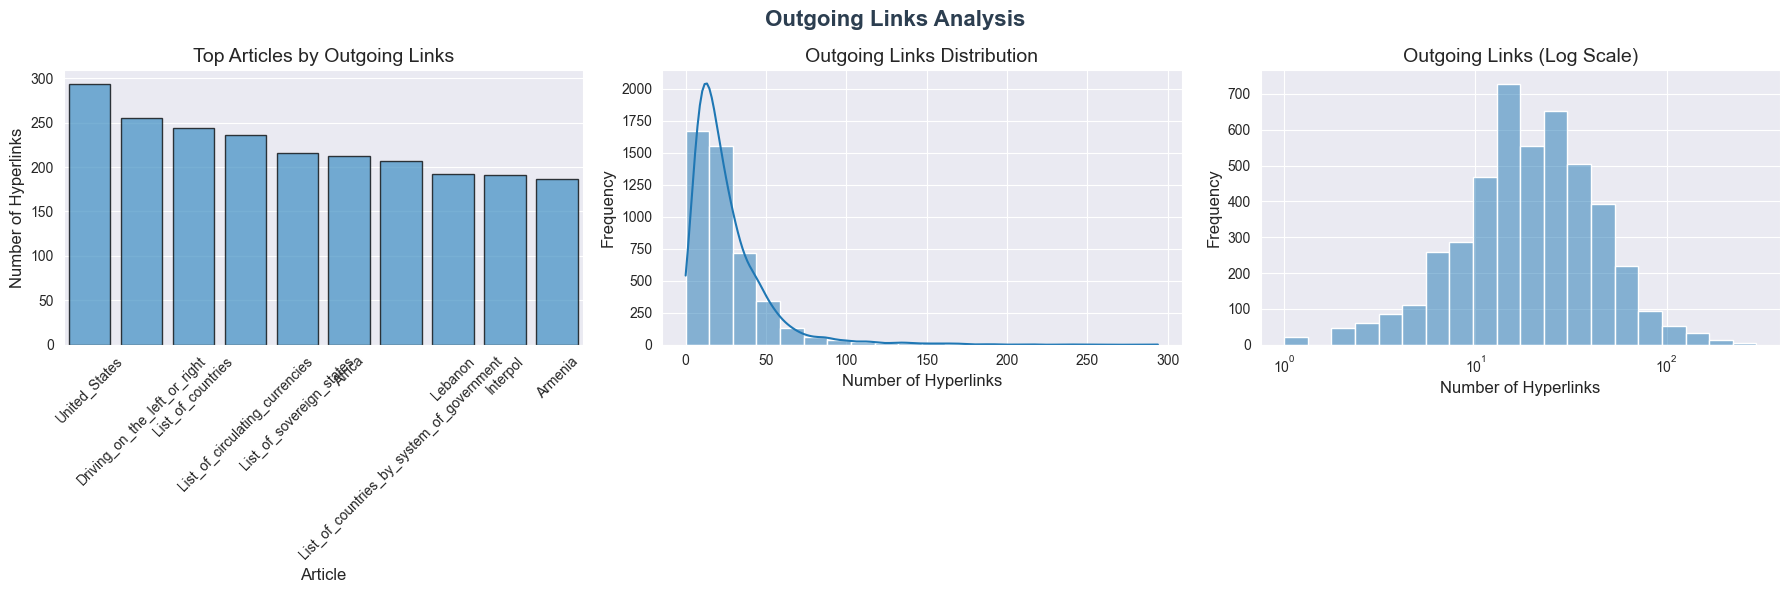

In [6]:
# Add new attributes
article_df = add_num_hyperlinks(article_df)
# Generate plots
plot_outgoing_links(article_df)

**Comment:** It’s interesting to see that the "United States" article is the most important node in our network. This article consistently ranks highly across different measures. It often appears in the shortest paths between articles and is a common stop in players’ successful games. Because of this, it’s not surprising that it also has the highest number of both incoming and outgoing hyperlinks. We can also notice that some articles, like "List_of_countries," are mostly collections of hyperlinks. These types of articles act as hubs or directories with lots of outgoing hyperlinks, which is why they stand out when looking at hyperlink numbers. The summary statistics and the above distribution reveal that the number of outgoing links varies widely across articles. Most articles have between 11 and 33 outgoing links. However, the mean of 26 and the standard deviation (24.2) indicate that some articles have significantly more links, as highlighted by the maximum of 294, again highlighting disproportionnality of number of links per article.



### Hyperlink density

Here, we now focus on the attribute "hyperlink density", which combines the length of an article with the number of outgoing hyperlinks it pocesses.

Summary statistics for hyperlink density:
count    4604.000000
mean        0.001604
std         0.001573
min         0.000000
25%         0.000727
50%         0.001208
75%         0.001953
max         0.025199
Name: hyperlink_density, dtype: float64


/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


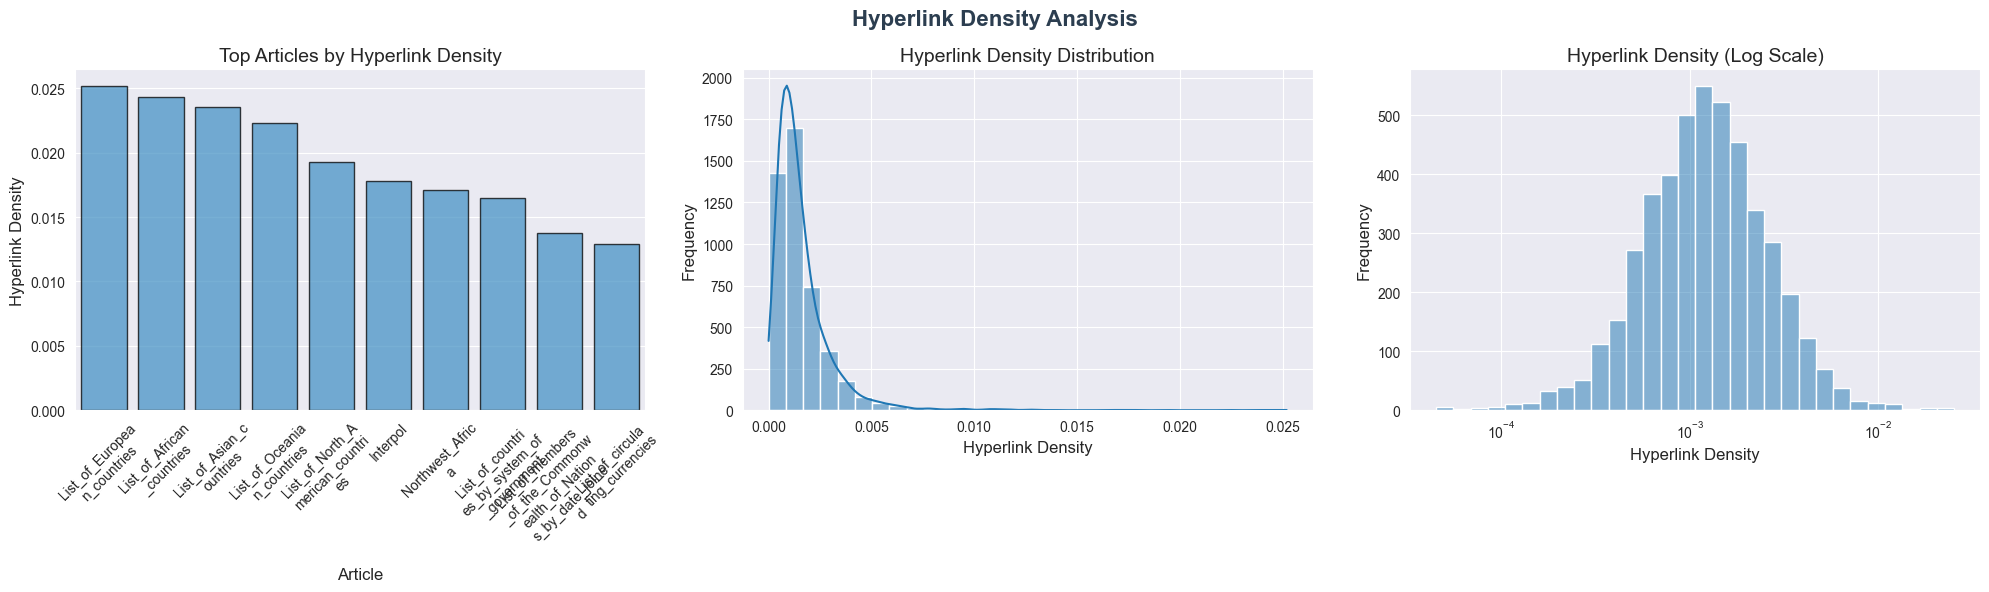

In [7]:
article_df = add_length_and_hyperlink_density(article_df)
plot_hyperlink_density(article_df)

**Comment:** We can see that all the articles with the highest hyperlink density are "List" articles. This makes sense, as these articles contain very little text, and nearly every item in the list is a hyperlink to another article. However, this suggests that hyperlink density might not be a reliable indicator of an article’s quality for efficient navigation.


### Number of characters

Here, we focus on the attribute "number of characters", which is an indication of the length of each article.

Summary statistics for number of characters:
count      4604.000000
mean      21232.968723
std       15508.639317
min         828.000000
25%        8811.750000
50%       17736.500000
75%       30104.750000
max      108718.000000
Name: num_characters, dtype: float64


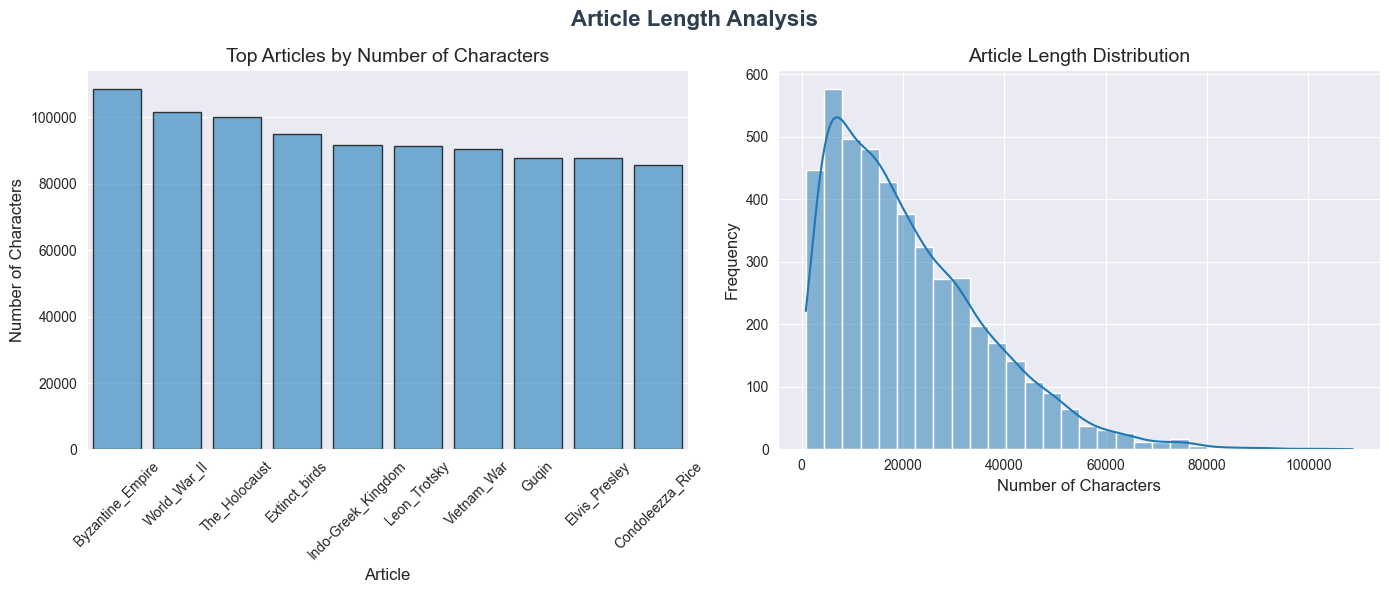

In [8]:
plot_article_length(article_df)

**Comment:** The top 10 articles with the highest letter count are dominated by historical events, likely because these events are long, well-documented, and contain a lot of information. In addition to historical events, three of the articles are biographical, indicating that articles about people can also have a high letter count which could be due to the detailed nature of their life histories leading to long articles. Most articles range between 8'000 and 30'000 characters, with a slight right skew due to a few very long articles, indicating considerable variation in article lengths.


### Semantic distance


We can compute basic semantic distance on articles simply by creating embeddings for the titles of the articles.

#### Computing the Embeddings :

First, let's compute the embeddings. We can follow a HuggingFace tutorial on generating text embeddings. This tutorial is found [here](https://huggingface.co/blog/getting-started-with-embeddings). For each title, we will generate an embedding, and store it in our dataframe.

In [9]:
import requests

In [10]:
import os

In [ ]:
## Code to get the embeddings
'''
# Extract all names
article_names = article_df['article']
article_names

# https://huggingface.co/blog/getting-started-with-embeddings
model_id = "sentence-transformers/all-MiniLM-L6-v2"
hf_token = os.environ.get("HUGGINGFACE_API_KEY")


api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{model_id}"
headers = {"Authorization": f"Bearer {hf_token}"}

def query(texts):
    response = requests.post(api_url, headers=headers, json={"inputs": texts, "options":{"wait_for_model":True}})
    return response.json()

article_names_list = article_names.tolist()
article_names_list = [name.replace("_", " ") for name in article_names_list]


# Call the API to create the embeddings
output = query(article_names_list)

# Store the embeddings in the df
article_df['embeddings'] = output

# See the dimensionality of our embeddings
# print(f'Dimensionality of Embeddings: {len(article_df["embeddings"][0])}')
'''

### Analyzing the Embeddings

There are lots of tools to visualize and analyze embeddings. In order to extract meaningful representations, a common tactic is to reduce the dimensionality of the embeddings. The two main tools for this are PCA and T-SNE.
See [here](https://distill.pub/2016/misread-tsne/) for a great overview on T-SNE.
We can use both of these via scikit-learn. For now, we just want to get a feel for the data. Let's use tensorflow's Embedding Projector tool. This tool can be hosted locally or used in a browser.

#### Embedding Projector

Embedding Projector is a useful tool made by TF to look at word embedding spaces. Let's save our data so it can be opened there.

https://projector.tensorflow.org/

Note that the embedding projector can also be used locally.

### Exporting Metadata and Embeddings for Embedding Projector

In order to use Embedding Projector, we need to export the embeddings and metadata in tsv format. We want to also explore how well title embeddings capture semantic distance between categories, so we will include category information in our metadata.

In [ ]:
# Separate embeddings as a new DataFrame
'''
embeddings_df = pd.DataFrame(article_df['embeddings'].tolist())

# Save embeddings to TSV
embeddings_df.to_csv('Data/embeddings/embeddings.tsv', sep='\t', header=False, index=False)
'''

The number of categories is different per article, as is the number of sub-categories per category listing.

In [ ]:
max_category_length = 0
max_num_categories= 0
for category in article_df['category']:
    if category is None or category is np.nan:
        continue
    if len(category) > max_num_categories:
        max_num_categories = len(category)
    for c in category:
        split_at_period = c.split('.')
        if len(split_at_period) > max_category_length:
            max_category_length = len(split_at_period)

print(max_category_length)
print(max_num_categories)

In [ ]:
# Expand categories into multiple subcategory levels

# Prepare a DataFrame for metadata
metadata_df = article_df[['article']].copy()

# Parse category information into separate columns
category_columns = [f'category_{j+1}_level_{i+1}' for j in range(max_num_categories) for i in range(max_category_length)]

for i in range(max_num_categories):
    for j in range(max_category_length):
        metadata_df[f'category_{i+1}_level{j+1}'] = article_df['category'].apply(
            lambda x: x[i].split('.')[j] if x is not np.nan and i < len(x) and j < len(x[i].split('.')) else None
        )

# We can drop the "level1" category, as it is always the string 'subject'
metadata_df = metadata_df.drop(columns=['category_1_level1', 'category_2_level1'], axis=1)

# # Save metadata to TSV
metadata_df.to_csv('Data/embeddings/metadata.tsv', sep='\t', header=True, index=False)

### TF's Embedding Projector

After saving our embeddings and their required metadata according to EmbeddingProjector's specifications, we can load the data into the tool. For now, let's use T-SNE in order to group the data. Here is what the data looks like after 1000 iterations of T-SNE:

![Default projections](Figures/default_1000_tsne.png=300)

But . . . does it even work? Well, let's do a gut check. What is that clump of titles at the top?

![Tropical Storms](Figures/tropical_storms.png)

Interesting! It seems like tropical storms are on a level of their own! That is, they share semantic meaning with each other but not other titles.Let's look at some common according to our statistics. For example, what is close to the United States?

![US TSNE](Figures/UnitedStates_TSNE.png)

We can also see what is close to the `United_States` title in the original, unprojected space. Cosine and Euclidean distance are both easily implementable in python, and already exist in multiple packages like scikit-learn.

![US Nearest](Figures/US_Nearest.png)

This Euclidean/Cosine distance will serve as our metric for semantic distance.


Here, we calculate the minimum and maximum semantic distances (cosine distances) for each article relative to the articles it links to. The minimum distance identifies the article’s closest thematic neighbor, while the maximum distance reveals its most conceptually distant linked article. By focusing on the top and bottom n articles—those with the highest and lowest mean cosine distances—we gain insight into how tightly clustered or widely dispersed their connections are, thereby understanding both the nearest and farthest thematic reaches accessible via a single link.

In [ ]:
from src.scripts.play_wikispeedia_greedy import average_outgoing_cosine_distance

In [20]:
embeddings = pd.read_csv('Data/embeddings/embeddings.tsv', sep='\t', header=None)
article_df = average_outgoing_cosine_distance(article_df, n=3)
plot_average_extreme_cosine_distances(article_df)

NameError: name 'average_outgoing_cosine_distance' is not defined

/Users/oscargoudet/Desktop/ada-2024-project-adaholiks/src/scripts/article_processing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_column_embeddings.rename(columns={'array': 'embeddings'}, inplace=True)


Summary statistics for average max cosine distance:
count    4587.000000
mean        0.864626
std         0.074385
min         0.194418
25%         0.830799
50%         0.871130
75%         0.908711
max         1.063881
Name: average_max_cosine_distance, dtype: float64

Summary statistics for average min cosine distance:
count    4587.000000
mean        0.510988
std         0.162154
min         0.046073
25%         0.386452
50%         0.508829
75%         0.636564
max         0.971088
Name: average_min_cosine_distance, dtype: float64


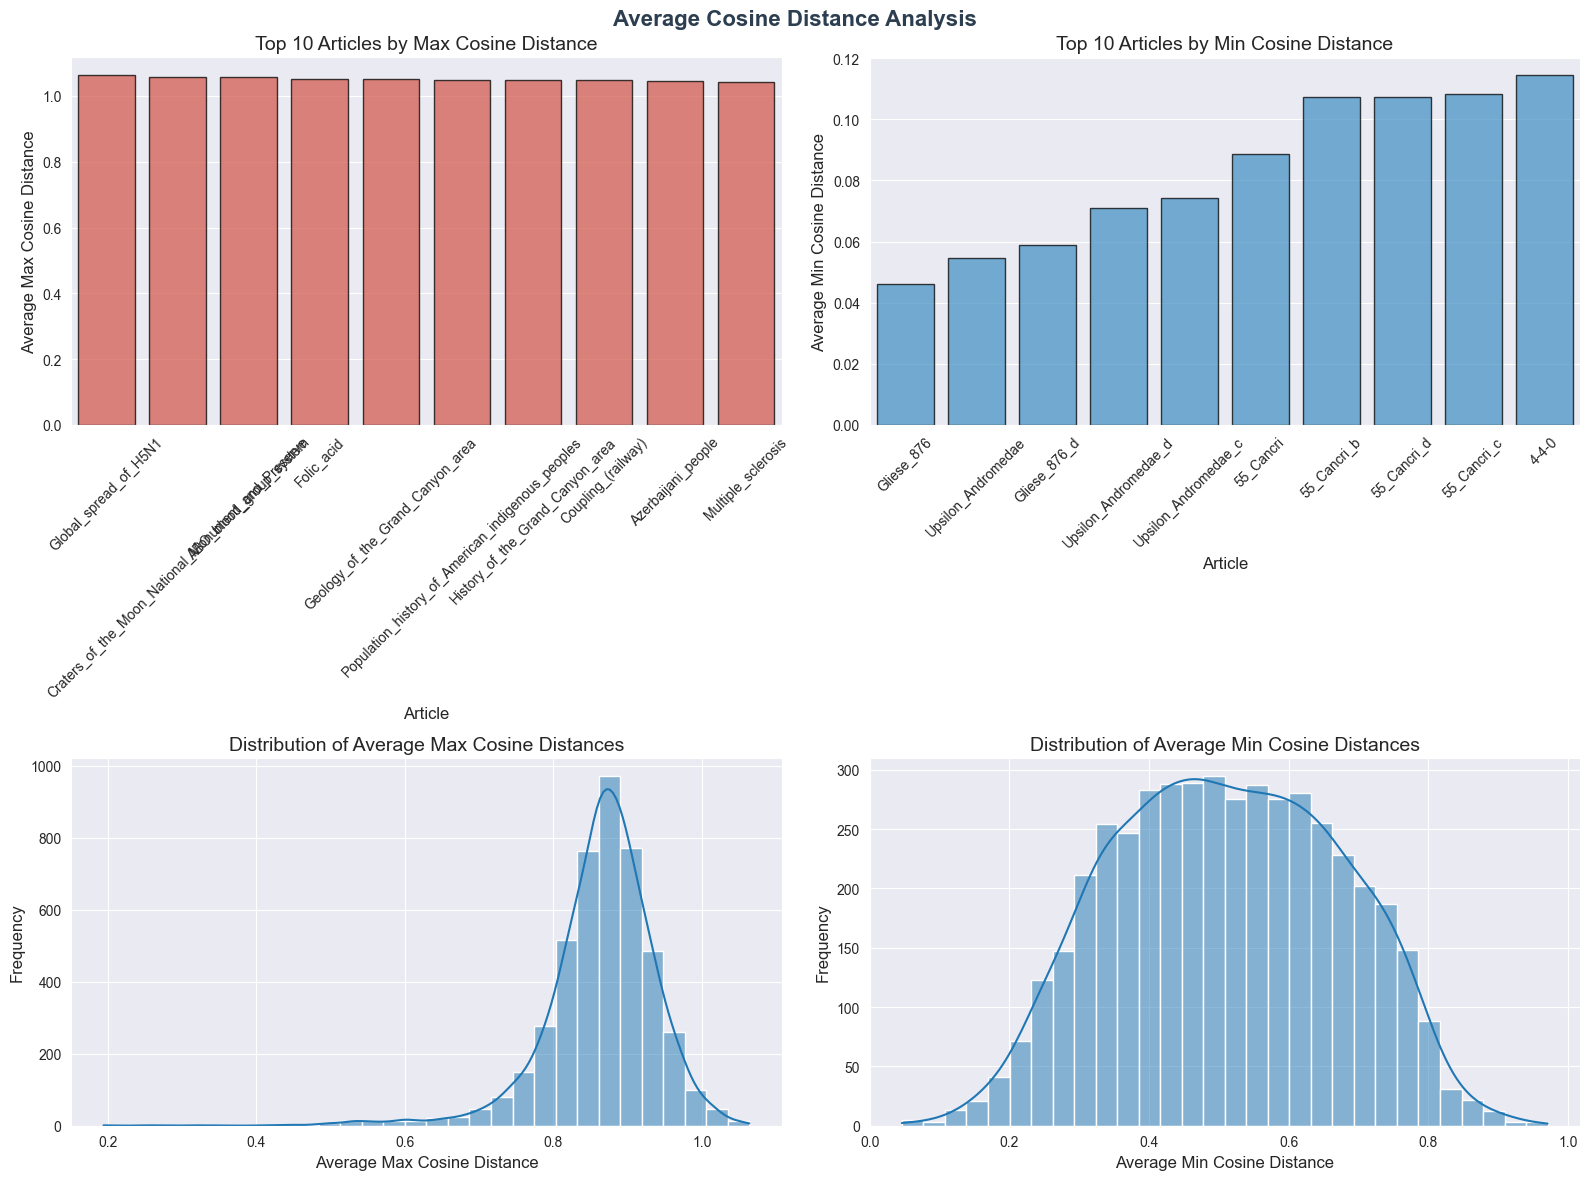

In [9]:
## Temporary cell till clay's functions are fixed
embeddings = pd.read_csv('Data/embeddings/embeddings.tsv', sep='\t', header=None)
article_df = add_average_extreme_cosine_distances(article_df,embeddings,n=3)
plot_average_extreme_cosine_distances(article_df)

**Comment:** The average max cosine distances cluster tightly around ~0.86, indicating that even the closest pairs at the “maximum difference” end are quite distinct. This distribution is relatively narrow, suggesting consistent diversity within the articles.

In contrast, the average min cosine distances are more varied, with values spread widely from near-zero (very similar) to nearly one (very different). The broader spread and higher standard deviation reflect greater variability in how closely some portions of the text align, indicating that some pairs are quite similar while others are surprisingly distant.

#### Categories in Embedding Space

After projecting using T-SNE, we can see how well the title embeddings align with categories. Here is the embedding projector, with each sub-category assigned its own color.

![Embeddings By Subject](Figures/embeddings_subject.png)

### A New Metric: Greedy Wikispeedia on Embedding Distance

In addition to validating that embedding distance is a good instrumentalization of category, we also leveraged embedding distance to create a new way of playing the Wikispeedia game.

Our pre-existing paths, created by human players, represent many different strategies for the Wikispeedia game. In contrast, these new versions of the Wikispeedia paths hope to imitate how the game is (anectdotally) typically played: in a rush of common-knowledge association. 

For all of our "filtered" paths, we follow this strategy:
```
For each start, end in paths:
    current_article = start
    while current_article != end:
        Out of the possible next articles, choose the article that satisfies the following conditions:
            1. we have not visited
            2. has the smallest distance to the end of the path
        If no articles satisfy this, discard the path.
```

In [15]:
filtered_paths_list = []

for index, row in length_filt_finished_paths.iterrows():
    filtered_paths_list.append((row['start_article'], row['target_article']))

NameError: name 'length_filt_finished_paths' is not defined

In [ ]:
from src.scripts.play_wikispeedia_greedy import (
    play_path_list,
    calculate_avg_article_weights_greedy,
    calculate_sum_article_cweights_greedy,
    filter_greedy_paths
)

greedy_embedding_paths = play_path_list(article_df, filtered_paths_list)

In [ ]:
# In order to compare to player paths, we need to subtract 1 from length.
greedy_embedding_paths['path_lengths'] = greedy_embedding_paths['path'].apply(len).apply(lambda x : x-1)

In [ ]:
greedy_embedding_paths['path_lengths'].describe()

In [ ]:
greedy_embedding_paths.shape

Let's filter these paths in the same way we filtered the player paths; these are bot-created paths, after all.

In [ ]:
filtered_greedy_embedding_paths = filter_greedy_paths(greedy_embedding_paths)

In [ ]:
filtered_greedy_embedding_paths['path_lengths'].describe()

In [ ]:
filtered_greedy_embedding_paths.shape

Seems we kept about 18,000 paths. Plenty to use as a basis for our metrics.

In [ ]:
# Average Article Weight
avg_art_weight_df = calculate_avg_article_weights_greedy(filtered_greedy_embedding_paths)

In [ ]:
avg_art_weight_df.sort_values(by="weighted_avg", ascending=False).head(10)

In [ ]:
# Sum Article CWeights
sum_art_cweights_df = calculate_sum_article_cweights_greedy(greedy_embedding_paths)

In [ ]:
# Let's inspect some of the articles
sum_art_cweights_df.sort_values(by="weighted_sum", ascending=False).head(20)

Now that we have metrics computed on this mode of play of the Wikispeedia game, let's save them for analysis later against our attributes.

In [ ]:
art_greedy_traversal_scores = pd.merge(sum_art_cweights_df, avg_art_weight_df, how="inner", on="article")

In [ ]:
art_greedy_traversal_scores

'### Vocabulary richness

Another attribute that we think could be interesting is vocabulary richness. This could potentially be a good indicator of the quality of an article.

Summary statistics for vocabulary richness:
count    4604.000000
mean        0.369981
std         0.094584
min         0.121154
25%         0.299972
50%         0.353456
75%         0.426332
max         0.732673
Name: vocabulary_richness, dtype: float64


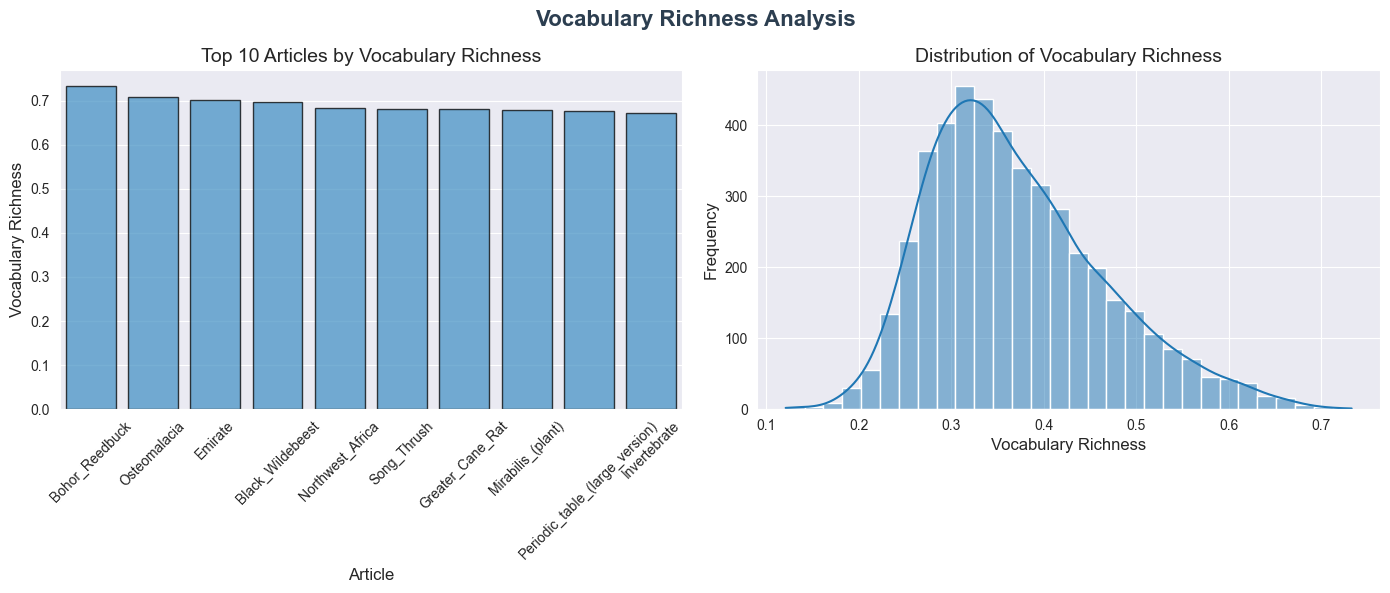

In [10]:
article_df = add_vocabulary_richness(article_df)
plot_vocabulary_richness(article_df)

**Comment:** The vocabulary richness has a mean of ~0.37 and a relatively small standard deviation (0.09), indicating moderate diversity in the word choice across articles. Most articles lie within the range of 0.12 to 0.73, with the majority showing a moderate level of richness in vocabulary. Some articles exhibit a higher richness, but overall, the distribution appears to be fairly concentrated around the lower to mid-range values.

## Graph based attributes

### Incoming hyperlinks

Here, we focus on the attribute "incoming hyperlinks", which represents how easily an article can be reached from other articles in the network that have a one-way hyperlink to it.

Summary statistics for incoming links:
count    4604.000000
mean       26.038662
std        62.746827
min         0.000000
25%         2.000000
50%         8.000000
75%        25.000000
max      1551.000000
Name: incoming_links, dtype: float64


/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


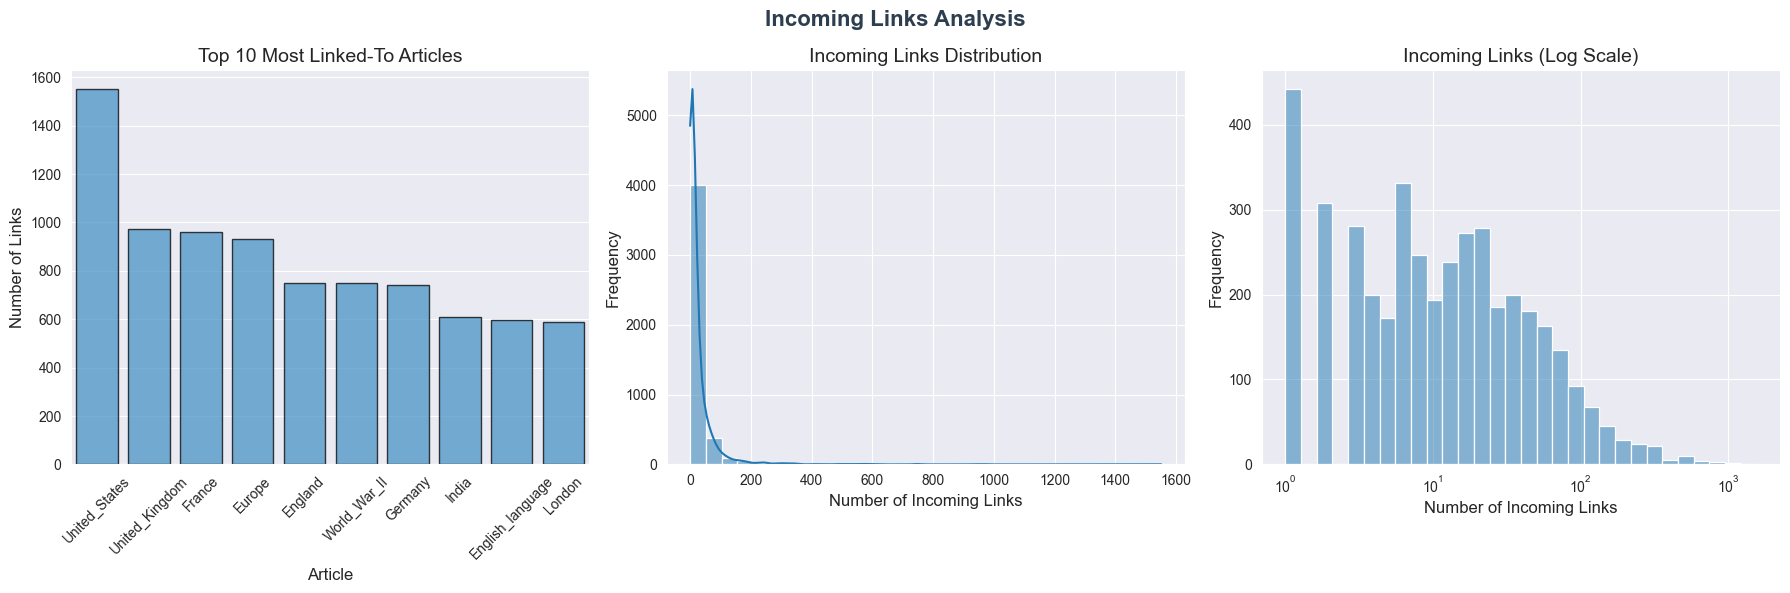

In [11]:
# Add new attributes
article_df = add_incoming_links(article_df)
# Generate plots
plot_incoming_links(article_df)

**Comment:** Here, we can observe that almost all of the top-linked articles are related to geography, geographical locations are often linked to a wide range of subjects which likely contributes to the higher number of incoming hyperlinks for these articles.
The distribution indicates that a small number of articles have a disproportionately large number of incoming links. compared to the rest of the network, these are the cenral hubs of the network ( e.g. United states article). With this heavy tail distribution we might think that it would be a good idea to filter out the outliers but in a systems like Wikispeedia (or any network), the heavy-tailed nature of link distributions is expected. Popular or highly connected articles likely play a central role in efficient navigation and removing any part of the distribution would skew our analysis and lead to biased results.

### page rank and betweenness centrality



PageRank is an algorithm originally used by Google to rank web pages in search results. It measures the importance of a node based on the number and quality of its incoming links. Links from important nodes contribute more significantly, reflecting a recursive importance structure. A node with many incoming links from other highly-ranked nodes will have a high PageRank. Betweenness Centrality measures how often a node acts as a bridge along the shortest path between other nodes, indicating its role in connecting different parts of the network. Both of those are computed using the networkx library

In [12]:
article_df = compute_graph_metrics(article_df)

---- WARNING: The following articles have a problem: ----
Badugi has no links (out-edges) listed.
Color_Graphics_Adapter has no links (out-edges) listed.
Directdebit has no category listed.
Directdebit has no links (out-edges) listed.
Donation has no category listed.
Donation has no links (out-edges) listed.
Douglas_DC-4 has no links (out-edges) listed.
Duchenne_muscular_dystrophy has no links (out-edges) listed.
Friend_Directdebit has no category listed.
Klinefelter%27s_syndrome has no links (out-edges) listed.
Local_community has no links (out-edges) listed.
Lone_Wolf_%28gamebooks%29 has no links (out-edges) listed.
Osteomalacia has no links (out-edges) listed.
Pikachu has no category listed.
Private_Peaceful has no links (out-edges) listed.
Schatzki_ring has no links (out-edges) listed.
Sponsorship_Directdebit has no category listed.
Suikinkutsu has no links (out-edges) listed.
Underground_%28stories%29 has no links (out-edges) listed.
Vacutainer has no links (out-edges) listed.
Wik

Summary statistics for pagerank:
count    4604.000000
mean        0.000217
std         0.000432
min         0.000033
25%         0.000044
50%         0.000086
75%         0.000215
max         0.009562
Name: pagerank, dtype: float64


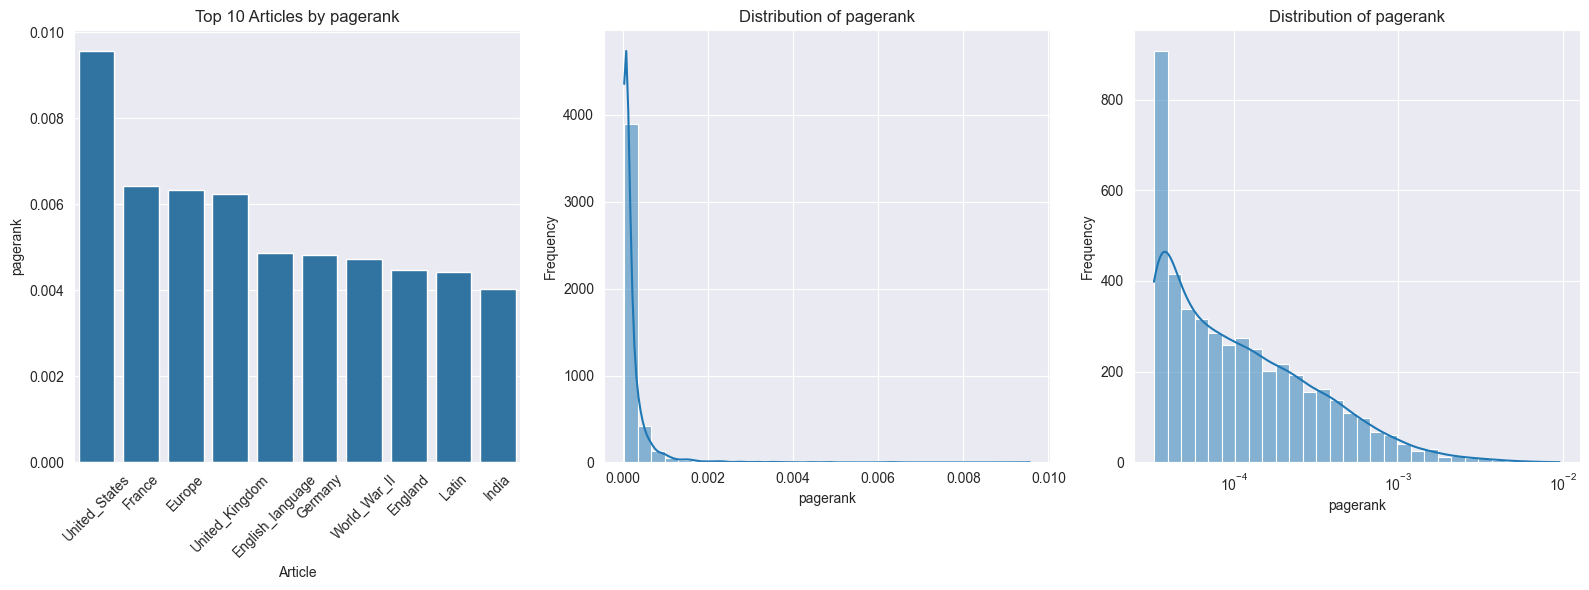

In [13]:
plot_graph_metric(article_df, 'pagerank', top_n=10)

Summary statistics for betweenness_centrality:
count    4604.000000
mean        0.000420
std         0.001968
min         0.000000
25%         0.000006
50%         0.000060
75%         0.000302
max         0.093600
Name: betweenness_centrality, dtype: float64


/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


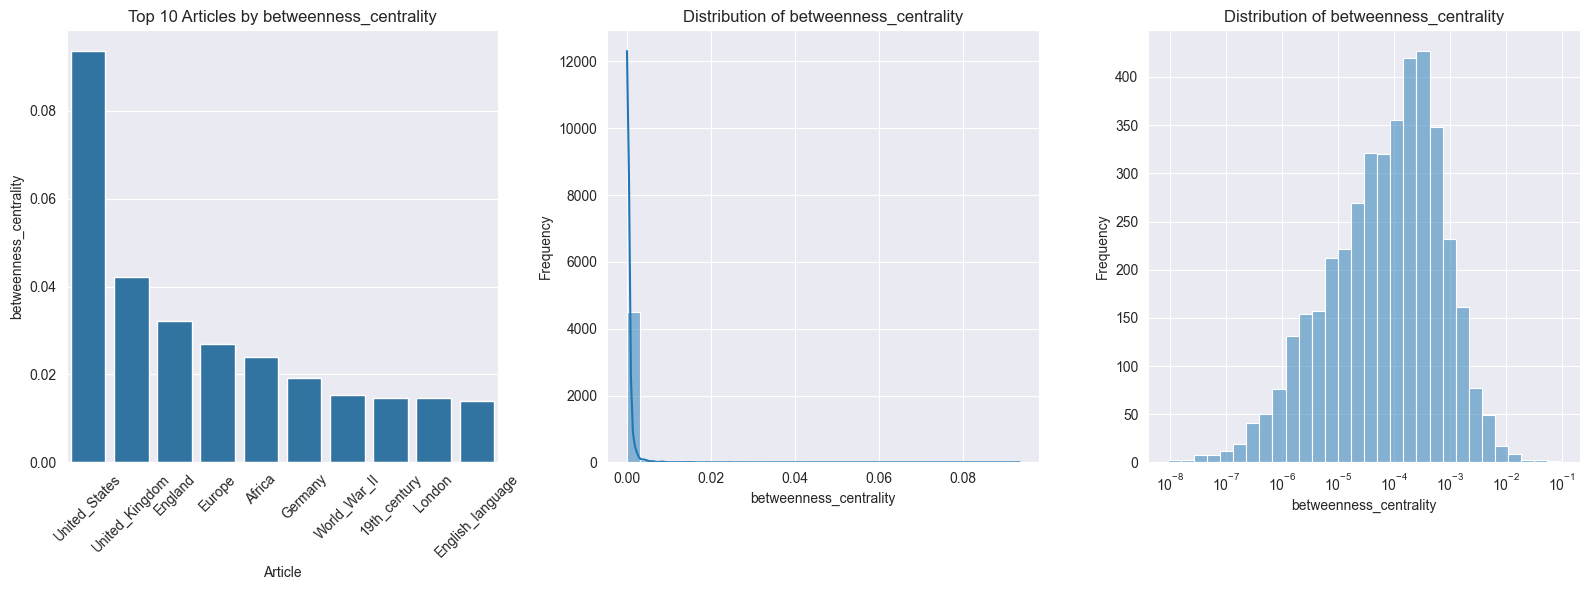

In [14]:
plot_graph_metric(article_df, 'betweenness_centrality', top_n=10)

**Comment:** The distribution of PageRank and Betweenness centrality values is highly skewed. This pattern reflects the network structure where just a few nodes emerge as major hubs, receiving many more incoming links compared to the majority. It’s not surprising to see “United_States” and other geographically significant articles rank highly, given that these entries consistently appeared among the top performers in other attributes as well. Their prominence across multiple metrics suggests that they are key reference points within this network, linking directly or indirectly to a broad range of topics. As a result, these geographical articles naturally emerge as major hubs, reflecting their central role in the overall structure of the graph.

In [16]:
article_df.to_feather('Data/dataframes/article_df_features.feather')

**END OF PREPROCESSING & exploratory data analysis**

# Part 2 : graph theory based top articles

**Comment:** In this analysis, we have divided the count by the total number of shortest paths for each source-target pair. This normalization helps us measure the true importance of each article in the network. Without normalization, an article that appears in every shortest path for a specific source-target pair might seem highly important, even if it doesn’t play a critical role across the entire network. By normalizing, we avoid overemphasizing articles that are only crucial within specific source-target pairs and ensure that the count more accurately reflects an article’s overall significance in the network.

$$
\text{Article k's Importance in (i ; j)} = \frac{A_{k}^{(i,j)}}{P^{(i,j)}}
$$

where:

$$
\begin{aligned}
A_{k}^{(i,j)} &= \text{Number of times article } k \text{ appears in shortest paths between source } i \text{ and target } j, \\
P^{(i,j)} &= \text{Total number of shortest paths between } i \text{ and } j.
\end{aligned}
$$



In [ ]:


paths_finished['finished'] = True
paths_finished['failure_reason'] = None

paths_finished['start_article'] = paths_finished['path'].apply(lambda x: x.split(';')[0])
paths_finished['target_article'] = paths_finished['path'].apply(lambda x: x.split(';')[-1])


paths_unfinished['finished'] = False

paths_unfinished.rename(columns={'type': 'failure_reason', 'target' : 'target_article'}, inplace=True)

paths_unfinished['start_article'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0])

paths = pd.concat([paths_finished, paths_unfinished])

finished_paths = paths[paths['finished'] == True]

unique_pairs = finished_paths[['start_article', 'target_article']].drop_duplicates()

pair_counts = finished_paths.groupby(['start_article', 'target_article']).size().reset_index(name='count')

#pair_counts

**Comment:** We also decided to concentrate our analysis on source-target pairs that are actually used in the game. By focusing only on these pairs, we generate a final list of articles that are theoretically advantageous for all possible gameplay scenarios. This approach prevents the inclusion of articles that may appear to be effective in connecting pairs not relevant to the game, which could otherwise skew the analysis.

In [ ]:
from collections import defaultdict
import networkx as nx
from src.graph_data import *


node_counts = defaultdict(int)

errors = 0

all_nb_of_shortest_paths = []

for _, row in pair_counts.iterrows():
    source = row['start_article']
    target = row['target_article']

    try:

        all_paths = list(nx.all_shortest_paths(G, source=source, target=target))

        nb_of_shortest_paths = len(all_paths)

        all_nb_of_shortest_paths.append(nb_of_shortest_paths)
        
        for path in all_paths:
            for node in path:
                if node != source and node != target:
                    node_counts[node] += 1/nb_of_shortest_paths

    except nx.NetworkXNoPath:
        # Skip this source-target pair if no path exists
        errors +=1


node_counts_df = pd.DataFrame(node_counts.items(), columns=['Node', 'ShortestPathCount'])

# Cleanup:
G=None

### Results

In [ ]:
# Sort by the 'ShortestPathCount' column in ascending order
node_counts_df = node_counts_df.sort_values(by='ShortestPathCount', ascending=False)
node_counts_df.head(20)

**Comment:** Here, we display the first 20 articles identified as most important across the network. These articles are ranked based on their normalized shortest path count, highlighting those that play a critical role in connecting various parts of the network. We can notice that topics related to influential countries (like the United States and the United Kingdom), broad regions (such as Europe and Africa), and significant historical events (like World War II) are among the highest-ranked. This suggests that geopolitical, regional, and historical themes are central to the network's structure, serving as key connectors across diverse topics.

In [ ]:
node_counts_df['ShortestPathCount'].describe()

**Comment:** 
- *Count :* Here, we see that 3'735 out of 4'604 articles are active nodes in the games network, representing about 81% of the total. This suggests that the majority of articles contribute to the games network's connectivity, while the remaining 19% may be more isolated or peripheral.
- *Mean :* The mean suggests most articles are not very important based on our metric. The quantiles support this, with the 25th and 50th percentiles showing that most articles appear in only a few shortest paths. A small number of articles are highly central, indicating a long-tailed distribution where a few nodes dominate the network.

# Part 4 : Analysis of the results found and correlation with attributes

In [ ]:
# temporary not to have to rerun eveything
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import requests
from sklearn.manifold import TSNE

from src.load_data import *
from src.graph_data import *
from src.utils import *
from src.scripts import *

In [ ]:
# new import list (add all needed imports here not)
import os
import pyarrow.feather as feather
from src.scripts.load_data import load_data
from src.scripts.convert_into_df import paths_to_df, articles_to_df
from src.scripts.path_processing import filter_paths
from src.scripts.backup_dfs import backup_dataframes
from src.utils.helpers import plot_path_length_distributions, plot_by_distance, plot_duration_histogram, plot_styled_bar_chart

Here we will study the correlation between our article attributes and the ranking metrics that we came up with. First we load our article dataframe and merge the different scores computed earlier to it. So we now have a dataframe the name of the article, its features and its score (quality/utility/speed).

In [17]:
# load article and score dataframes
article_df = feather.read_feather('Data/dataframes/article_df_features.feather')

quality_scores_clicks_df = feather.read_feather('Data/dataframes/quality_scores_clicks.feather')
utility_scores_clicks_df = feather.read_feather('Data/dataframes/utility_scores_clicks.feather')
time_scores = feather.read_feather('Data/dataframes/time_scores.feather')

top_4_quality_scores_df = feather.read_feather('Data/dataframes/top4_quality_scores_clicks.feather')
top_4_utility_scores_df = feather.read_feather('Data/dataframes/top4_utility_scores_clicks.feather')
top_4_time_scores_df = feather.read_feather('Data/dataframes/top_4_time_scores.feather')

top_1_quality_scores_df = feather.read_feather('Data/dataframes/top1_quality_scores_clicks.feather')
top_1_utility_scores_df = feather.read_feather('Data/dataframes/top1_utility_scores_clicks.feather')
top_1_time_scores_df = feather.read_feather('Data/dataframes/top_1_time_scores.feather')

In [18]:
article_df

,article,category,linkTarget,distances,plain_text,num_hyperlinks,num_characters,hyperlink_density,embeddings,average_max_cosine_distance,average_min_cosine_distance,vocabulary_richness,incoming_links,pagerank,betweenness_centrality
0,Áedán_mac_Gabráin,[subject.History.British_History.British_Histo...,"[Bede, Columba, Dál_Riata, Great_Britain, Irel...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÁedán mac Gabráin\n\n2007 Sch...,11,11612,0.000947,"[-0.1292391121387481, 0.0236219353973865, -0.0...",0.854584,0.725869,0.318346,0,0.000033,0.000000
1,Åland,"[subject.Countries, subject.Geography.European...","[20th_century, Baltic_Sea, Crimean_War, Curren...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÅland\n\n2007 Schools Wikiped...,19,17238,0.001102,"[-0.0536498501896858, -0.018478475511074, -0.0...",0.882111,0.688345,0.376456,0,0.000033,0.000000
2,Édouard_Manet,[subject.People.Artists],"[Absinthe, Beer, Claude_Monet, Diego_Velázquez...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉdouard Manet\n\n2007 Schools...,20,18996,0.001053,"[-0.0170925538986921, 0.0835338979959487, -0.0...",0.900127,0.561886,0.368298,0,0.000033,0.000000
3,Éire,"[subject.Countries, subject.Geography.European...","[Canada, English_language, George_VI_of_the_Un...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉire\n\n2007 Schools Wikipedi...,8,13083,0.000611,"[0.0483395084738731, 0.0465945191681385, 0.052...",0.789983,0.622838,0.329540,0,0.000033,0.000000
4,Óengus_I_of_the_Picts,[subject.History.British_History.British_Histo...,"[Dál_Riata, Durham, England, Great_Britain, Ir...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÓengus I of the Picts\n\n2007...,10,12944,0.000773,"[-0.076491080224514, 0.1048120632767677, -0.04...",0.882211,0.767841,0.333808,0,0.000033,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,Zionism,"[subject.People.Political_People, subject.Reli...","[18th_century, 19th_century, Adolf_Hitler, Alb...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZionism\n\n2007 Schools Wikip...,74,62086,0.001192,"[-0.0160204768180847, 0.0894060954451561, -0.0...",0.861760,0.390820,0.247640,25,0.000206,0.000239
4600,Zirconium,[subject.Science.Chemistry.Chemical_elements],"[Aluminium, Arabic_language, Australia, Bicycl...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZirconium\n\n2007 Schools Wik...,42,13253,0.003169,"[-0.1054912209510803, 0.0234880838543176, -0.1...",0.915593,0.522486,0.458779,15,0.000088,0.000068
4601,Zoroaster,[subject.People.Religious_figures_and_leaders],"[18th_century, 9th_century, Afghanistan, Age_o...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZoroaster\n\n2007 Schools Wik...,28,19726,0.001419,"[-0.0665727406740188, 0.1222779899835586, -0.0...",0.866142,0.687633,0.386653,9,0.000094,0.000056
4602,Zuid-Gelders,"[subject.Geography.European_Geography, subject...","[Brabantian, Dutch_language, East_Flemish, Hol...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZuid-Gelders\n\n2007 Schools ...,5,2341,0.002136,"[-0.173138827085495, 0.0952244028449058, 0.006...",0.883112,0.795226,0.488372,5,0.000087,0.000000


In [19]:
merged_quality_df = article_df.merge(quality_scores_clicks_df, on='article', how='inner')
merged_utility_df = article_df.merge(utility_scores_clicks_df, on='article', how='inner')
merged_time_df = article_df.merge(time_scores, on='article', how='inner')


merged_top_4_quality_scores_df = article_df.merge(top_4_quality_scores_df, on='article', how='inner')
merged_top_4_utility_scores_df = article_df.merge(top_4_utility_scores_df, on='article', how='inner')
merged_top_4_time_scores_df = article_df.merge(top_4_time_scores_df, on='article', how='inner')

merged_top_1_quality_scores_df = article_df.merge(top_1_quality_scores_df, on='article', how='inner')
merged_top_1_utility_scores_df = article_df.merge(top_1_utility_scores_df, on='article', how='inner')
merged_top_1_time_scores_df = article_df.merge(top_1_time_scores_df, on='article', how='inner')

In [20]:
from src.scripts.correlation_processing import  *
from src.utils.helpers import *

## Evaluation of the quality scores

We will first study the correlation between our article attributes and the quality score it got.

In [21]:
# drop all columns that are not attributes or scores from merged_df
merged_quality_df.drop(columns=['plain_text','category','linkTarget','distances','embeddings','n_appearances'], inplace=True)
merged_quality_df.set_index('article', inplace=True)

# standardize all columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_quality_df)
merged_quality_df = pd.DataFrame(scaled_data, columns=merged_quality_df.columns, index=merged_quality_df.index)
merged_quality_df.to_feather('Data/dataframes/merged_quality_df.feather')

In [22]:
merged_quality_df

,num_hyperlinks,num_characters,hyperlink_density,average_max_cosine_distance,average_min_cosine_distance,vocabulary_richness,incoming_links,pagerank,betweenness_centrality,composite_3,composite_2,PCA_composite_2
article,,,,,,,,,,,,
10th_century,-0.718114,-1.423198,1.643627,0.438178,-0.969921,3.728984,-0.340807,-0.231087,-0.330541,0.098679,0.191802,0.049374
12th_century,-0.153770,-1.371465,3.061565,-0.333289,-1.793254,3.144036,-0.193635,-0.135936,-0.166244,0.006915,-0.032122,0.064489
14th_century,-0.569602,-1.415767,2.122244,-0.437765,-1.157025,3.244384,-0.296655,-0.270776,-0.334528,-1.169108,-1.372925,-1.342685
15th_century,0.202658,-1.260178,2.950766,-0.353818,-2.099256,2.313192,-0.083256,0.100262,-0.083484,-0.925853,-0.821397,-0.698584
16th_century,1.212536,-0.988386,3.039033,1.072964,-1.921140,1.889664,0.100708,0.309371,0.265354,-0.845683,-1.065860,-1.023511
...,...,...,...,...,...,...,...,...,...,...,...,...
World_War_I,0.945216,2.814301,-0.613803,0.039744,-0.517806,-1.230341,2.153751,1.897014,0.923648,0.599991,0.596228,0.522903
World_War_II,2.044201,3.937392,-0.508662,0.108924,0.590105,-2.010398,4.707178,4.284538,2.678213,1.115712,1.153242,1.100098
World_Wide_Web,-0.896328,-0.453908,-0.701771,-0.033243,1.145327,-0.303976,-0.664584,-0.681078,-0.228720,0.015764,-0.082457,-0.066378


{'composite_3': num_hyperlinks                 0.289792
num_characters                 0.271088
hyperlink_density             -0.020763
average_max_cosine_distance    0.284438
average_min_cosine_distance   -0.181926
vocabulary_richness           -0.202564
incoming_links                 0.197799
pagerank                       0.154097
betweenness_centrality         0.221512
dtype: float64, 'composite_2': num_hyperlinks                 0.280752
num_characters                 0.283899
hyperlink_density             -0.035055
average_max_cosine_distance    0.267440
average_min_cosine_distance   -0.149468
vocabulary_richness           -0.210504
incoming_links                 0.206132
pagerank                       0.163996
betweenness_centrality         0.231270
dtype: float64}


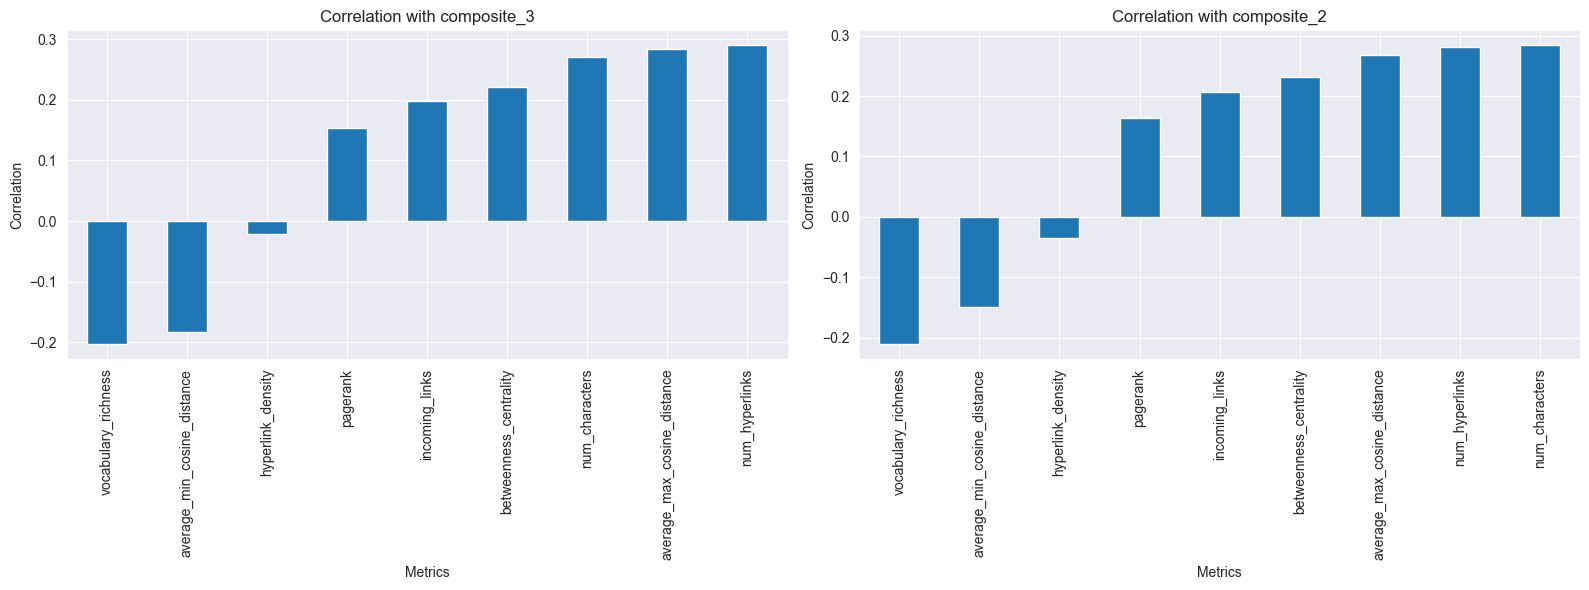

In [34]:
attributes = [ 'num_hyperlinks', 'num_characters', 'hyperlink_density', 'average_max_cosine_distance','average_min_cosine_distance', 'vocabulary_richness','incoming_links','pagerank','betweenness_centrality']
composites = ['composite_3', 'composite_2']
correlations = correlate_attributes(merged_quality_df, attributes, composites)
print(correlations)
plot_correlations(correlations)

**Comment:** We see that we have no very strong correlations between any of our attributes and our quality scores. But it is interesting to notice that the max cosine distance is one of the attributes that is the most strongly correlated to a good score. It suggests that these articles link not just to closely related content but also to more conceptually distant topics, potentially making them valuable stepping stones to a variety of other areas thus improving there quality for the game. It is also not surprsing

## Evaluation of the utility scores


In [24]:
merged_utility_df

,article,category,linkTarget,distances,plain_text,num_hyperlinks,num_characters,hyperlink_density,embeddings,average_max_cosine_distance,average_min_cosine_distance,vocabulary_richness,incoming_links,pagerank,betweenness_centrality,n_appearances,composite_3,composite_2
0,10th_century,[subject.History.General_history],"[11th_century, 9th_century, Algeria, Beer, Bla...","{'10th_century': 0.0, '11th_century': 1.0, '12...",#copyright\n\n10th century\n\n2007 Schools ...,26,5713,0.004551,"[-0.0868638157844543, 0.0847523063421249, -0.0...",0.879901,0.251242,0.582649,65,0.000631,0.000526,31.0,-0.211229,-0.207006
1,12th_century,[subject.History.General_history],"[10th_century, 11th_century, 13th_century, 14t...","{'10th_century': 1.0, '11th_century': 1.0, '12...",#copyright\n\n12th century\n\n2007 Schools ...,45,6639,0.006778,"[-0.0757509544491767, 0.1027827262878418, -0.1...",0.834469,0.166685,0.542683,85,0.000718,0.001340,40.0,0.230824,0.216492
2,14th_century,[subject.History.General_history],"[13th_century, 15th_century, Abacus, Aztec, Bl...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\n14th century\n\n2007 Schools ...,31,5846,0.005303,"[-0.1069932803511619, 0.1157033815979957, -0.0...",0.828317,0.232026,0.549539,71,0.000595,0.000507,35.0,-0.167161,-0.309622
3,15th_century,[subject.History.General_history],"[10th_century, 11th_century, 12th_century, 13t...","{'10th_century': 1.0, '11th_century': 1.0, '12...",#copyright\n\n15th century\n\n2007 Schools ...,57,8631,0.006604,"[-0.0816465765237808, 0.1113934516906738, -0.0...",0.833260,0.135258,0.485915,100,0.000932,0.001749,53.0,-0.127607,-0.033976
4,16th_century,[subject.History.General_history],"[10th_century, 11th_century, 12th_century, 13t...","{'10th_century': 1.0, '11th_century': 1.0, '12...",#copyright\n\n16th century\n\n2007 Schools ...,91,13496,0.006743,"[-0.0125136654824018, 0.0909469500184059, -0.0...",0.917284,0.153551,0.456978,125,0.001121,0.003476,69.0,-0.163446,-0.338788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,World_War_I,[subject.History.Military_History_and_War],"[Africa, Albania, Baghdad, Battle_of_Amiens, B...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nWorld War I\n\n2007 Schools W...,82,81563,0.001005,"[-0.051502950489521, 0.0447914265096187, -0.01...",0.856437,0.297675,0.243804,404,0.002559,0.006734,242.0,0.302032,0.290858
623,World_War_II,[subject.History.British_History.British_Histo...,"[Adolf_Hitler, Aircraft, Aircraft_carrier, Alb...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nWorld War II\n\n2007 Schools ...,119,101666,0.001170,"[-0.0317188762128353, 0.0827357470989227, -0.0...",0.860511,0.411459,0.190506,751,0.004723,0.015419,817.0,1.803899,2.065698
624,World_Wide_Web,[subject.IT.Websites_and_the_Internet],"[Ajax_(programming), Book, C++, Chinese_langua...","{'10th_century': 2.0, '11th_century': 3.0, '12...",#copyright\n\nWorld Wide Web\n\n2007 School...,20,23063,0.000867,"[-0.0529951564967632, -0.06702421605587, -0.01...",0.852139,0.468481,0.307097,21,0.000224,0.001030,95.0,0.047741,-0.047360
625,Yellowstone_National_Park,[subject.Geography.North_American_Geography],"[American_Civil_War, Animal_rights, Atlantic_O...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nYellowstone National Park\n\n...,29,30425,0.000953,"[-0.0121887419372797, 0.046813853085041, 0.052...",0.932560,0.562999,0.305835,18,0.000148,0.000743,42.0,-1.587029,-1.595828


In [25]:
# drop all columns that are not attributes or scores from merged_df
merged_utility_df.drop(columns=['plain_text','category','linkTarget','distances','embeddings','n_appearances'], inplace=True)
merged_utility_df.set_index('article', inplace=True)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_utility_df)
merged_utility_df = pd.DataFrame(scaled_data, columns=merged_utility_df.columns, index=merged_utility_df.index)
merged_utility_df.to_feather('Data/dataframes/merged_utility_df.feather')

In [26]:
merged_utility_df

,num_hyperlinks,num_characters,hyperlink_density,average_max_cosine_distance,average_min_cosine_distance,vocabulary_richness,incoming_links,pagerank,betweenness_centrality,composite_3,composite_2
article,,,,,,,,,,,
10th_century,-0.718114,-1.423198,1.643627,0.438178,-0.969921,3.728984,-0.340807,-0.231087,-0.330541,-0.378592,-0.312027
12th_century,-0.153770,-1.371465,3.061565,-0.333289,-1.793254,3.144036,-0.193635,-0.135936,-0.166244,0.272686,0.247549
14th_century,-0.569602,-1.415767,2.122244,-0.437765,-1.157025,3.244384,-0.296655,-0.270776,-0.334528,-0.313667,-0.447615
15th_century,0.202658,-1.260178,2.950766,-0.353818,-2.099256,2.313192,-0.083256,0.100262,-0.083484,-0.255391,-0.083399
16th_century,1.212536,-0.988386,3.039033,1.072964,-1.921140,1.889664,0.100708,0.309371,0.265354,-0.308192,-0.486153
...,...,...,...,...,...,...,...,...,...,...,...
World_War_I,0.945216,2.814301,-0.613803,0.039744,-0.517806,-1.230341,2.153751,1.897014,0.923648,0.377597,0.345809
World_War_II,2.044201,3.937392,-0.508662,0.108924,0.590105,-2.010398,4.707178,4.284538,2.678213,2.590305,2.690936
World_Wide_Web,-0.896328,-0.453908,-0.701771,-0.033243,1.145327,-0.303976,-0.664584,-0.681078,-0.228720,0.002949,-0.101084


{'composite_3': num_hyperlinks                 0.289792
num_characters                 0.271088
hyperlink_density             -0.020763
average_max_cosine_distance    0.284438
average_min_cosine_distance   -0.181926
vocabulary_richness           -0.202564
incoming_links                 0.197799
pagerank                       0.154097
betweenness_centrality         0.221512
dtype: float64, 'composite_2': num_hyperlinks                 0.280752
num_characters                 0.283899
hyperlink_density             -0.035055
average_max_cosine_distance    0.267440
average_min_cosine_distance   -0.149468
vocabulary_richness           -0.210504
incoming_links                 0.206132
pagerank                       0.163996
betweenness_centrality         0.231270
dtype: float64}


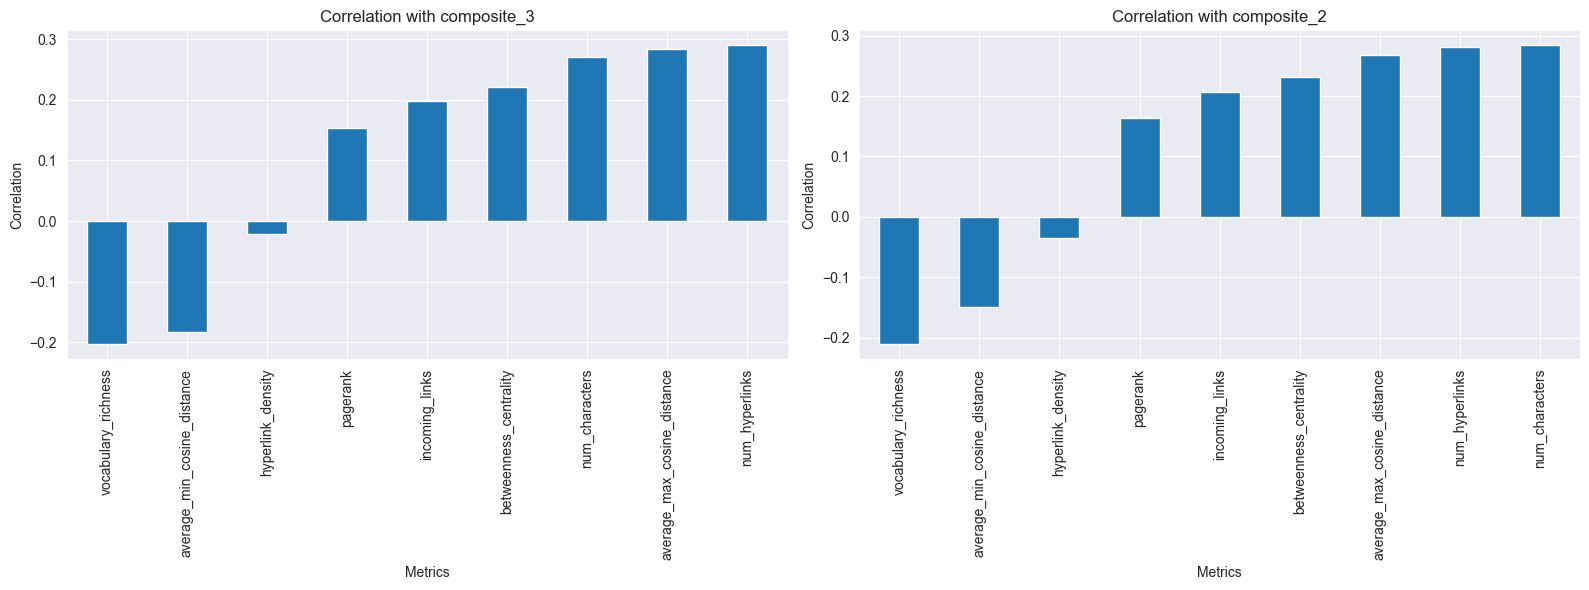

In [27]:
attributes = [ 'num_hyperlinks', 'num_characters', 'hyperlink_density', 'average_max_cosine_distance','average_min_cosine_distance', 'vocabulary_richness','incoming_links','pagerank','betweenness_centrality']
composites = ['composite_3', 'composite_2']

correlations = correlate_attributes(merged_quality_df, attributes, composites)
print(correlations)
plot_correlations(correlations)

COMMENT

## Evaluation of the speed scores

In [28]:
merged_time_df

,article,category,linkTarget,distances,plain_text,num_hyperlinks,num_characters,hyperlink_density,embeddings,average_max_cosine_distance,average_min_cosine_distance,vocabulary_richness,incoming_links,pagerank,betweenness_centrality,n_appearances,avg_adj_time_scaled,sum_cadj_time_scaled
0,10th_century,[subject.History.General_history],"[11th_century, 9th_century, Algeria, Beer, Bla...","{'10th_century': 0.0, '11th_century': 1.0, '12...",#copyright\n\n10th century\n\n2007 Schools ...,26,5713,0.004551,"[-0.0868638157844543, 0.0847523063421249, -0.0...",0.879901,0.251242,0.582649,65,0.000631,0.000526,37.0,1.600293,0.238176
1,11th_century,[subject.History.General_history],"[10th_century, 12th_century, 13th_century, 14t...","{'10th_century': 1.0, '11th_century': 0.0, '12...",#copyright\n\n11th century\n\n2007 Schools ...,48,7734,0.006206,"[-0.1139559671282768, 0.0889145657420158, -0.0...",0.859697,0.126177,0.535893,57,0.000545,0.000628,31.0,0.423303,0.059450
2,12th_century,[subject.History.General_history],"[10th_century, 11th_century, 13th_century, 14t...","{'10th_century': 1.0, '11th_century': 1.0, '12...",#copyright\n\n12th century\n\n2007 Schools ...,45,6639,0.006778,"[-0.0757509544491767, 0.1027827262878418, -0.1...",0.834469,0.166685,0.542683,85,0.000718,0.001340,49.0,1.566281,0.236888
3,13th_century,[subject.History.General_history],"[12th_century, 14th_century, Angola, Arabic_la...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\n13th century\n\n2007 Schools ...,34,6090,0.005583,"[-0.0990192592144012, 0.0722229406237602, -0.1...",0.807042,0.311465,0.611696,84,0.000755,0.000807,38.0,1.278852,0.193611
4,14th_century,[subject.History.General_history],"[13th_century, 15th_century, Abacus, Aztec, Bl...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\n14th century\n\n2007 Schools ...,31,5846,0.005303,"[-0.1069932803511619, 0.1157033815979957, -0.0...",0.828317,0.232026,0.549539,71,0.000595,0.000507,42.0,1.460079,0.295198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,World_War_I,[subject.History.Military_History_and_War],"[Africa, Albania, Baghdad, Battle_of_Amiens, B...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nWorld War I\n\n2007 Schools W...,82,81563,0.001005,"[-0.051502950489521, 0.0447914265096187, -0.01...",0.856437,0.297675,0.243804,404,0.002559,0.006734,240.0,0.102888,-0.168976
660,World_War_II,[subject.History.British_History.British_Histo...,"[Adolf_Hitler, Aircraft, Aircraft_carrier, Alb...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nWorld War II\n\n2007 Schools ...,119,101666,0.001170,"[-0.0317188762128353, 0.0827357470989227, -0.0...",0.860511,0.411459,0.190506,751,0.004723,0.015419,785.0,-0.021307,-1.178492
661,World_Wide_Web,[subject.IT.Websites_and_the_Internet],"[Ajax_(programming), Book, C++, Chinese_langua...","{'10th_century': 2.0, '11th_century': 3.0, '12...",#copyright\n\nWorld Wide Web\n\n2007 School...,20,23063,0.000867,"[-0.0529951564967632, -0.06702421605587, -0.01...",0.852139,0.468481,0.307097,21,0.000224,0.001030,102.0,-0.638714,-0.712197
662,Yellowstone_National_Park,[subject.Geography.North_American_Geography],"[American_Civil_War, Animal_rights, Atlantic_O...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nYellowstone National Park\n\n...,29,30425,0.000953,"[-0.0121887419372797, 0.046813853085041, 0.052...",0.932560,0.562999,0.305835,18,0.000148,0.000743,49.0,-2.828948,-0.868869


In [29]:
# drop all columns that are not attributes or scores from merged_df
merged_time_df.drop(columns=['plain_text','category','linkTarget','distances','embeddings','n_appearances'], inplace=True)
merged_time_df.set_index('article', inplace=True)

# standardize all columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_time_df)
merged_time_df = pd.DataFrame(scaled_data, columns=merged_time_df.columns, index=merged_time_df.index)
merged_time_df.to_feather('Data/dataframes/merged_time_df.feather')

{'avg_adj_time_scaled': num_hyperlinks                 0.126084
num_characters                -0.127909
hyperlink_density              0.188947
average_max_cosine_distance   -0.011703
average_min_cosine_distance   -0.164382
vocabulary_richness            0.160004
incoming_links                 0.191900
pagerank                       0.183402
betweenness_centrality         0.152522
dtype: float64, 'sum_cadj_time_scaled': num_hyperlinks                 0.404512
num_characters                 0.017073
hyperlink_density              0.216619
average_max_cosine_distance    0.092376
average_min_cosine_distance   -0.162280
vocabulary_richness            0.026635
incoming_links                 0.559104
pagerank                       0.514881
betweenness_centrality         0.697843
dtype: float64}


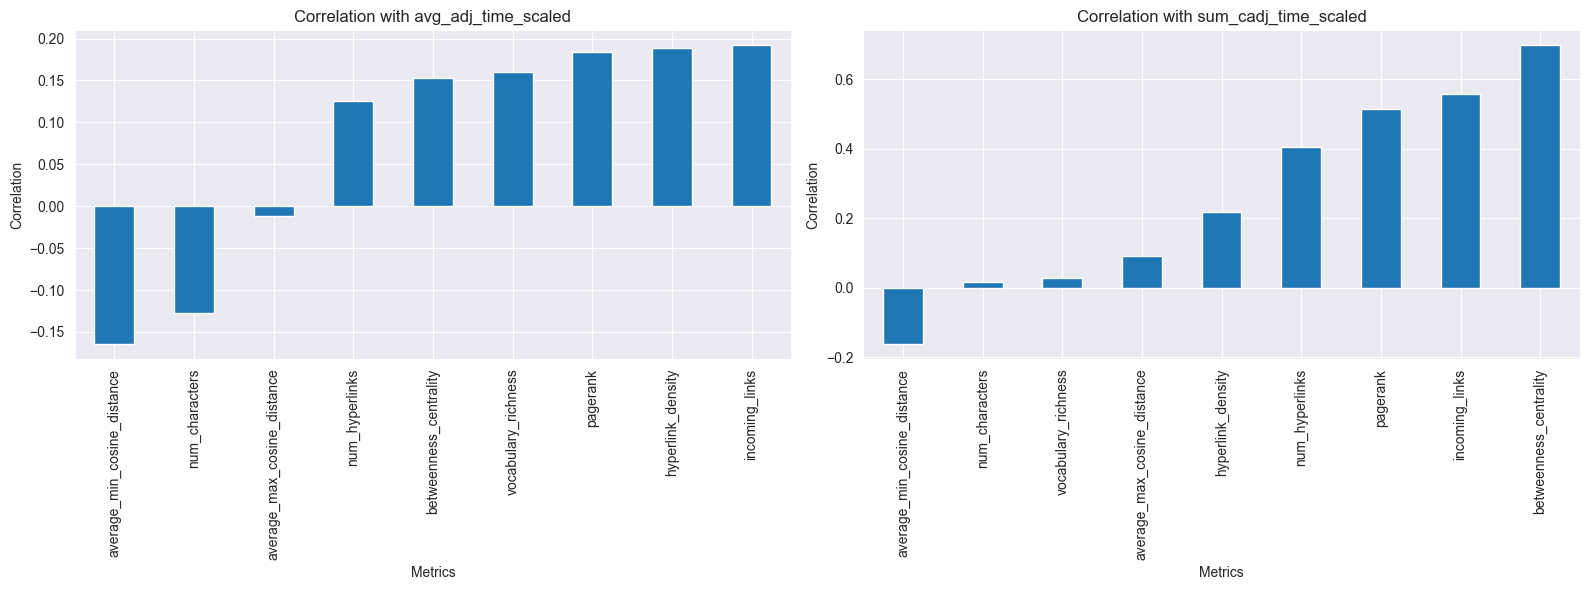

In [30]:
attributes = [ 'num_hyperlinks', 'num_characters', 'hyperlink_density', 'average_max_cosine_distance','average_min_cosine_distance', 'vocabulary_richness','incoming_links','pagerank','betweenness_centrality']
composites = ['avg_adj_time_scaled', 'sum_cadj_time_scaled']

correlations = correlate_attributes(merged_time_df, attributes, composites)
print(correlations)
plot_correlations(correlations)

## Evaluation of top 1 quality clicks


In [31]:
merged_top_1_quality_scores_df

,article,category,linkTarget,distances,plain_text,num_hyperlinks,num_characters,hyperlink_density,embeddings,average_max_cosine_distance,average_min_cosine_distance,vocabulary_richness,incoming_links,pagerank,betweenness_centrality,n_appearances,composite_3,composite_2,PCA_composite_2
0,Alexander_Graham_Bell,[subject.People.Engineers_and_inventors],"[Bath,_Somerset, Boston,_Massachusetts, Califo...","{'10th_century': 2.0, '11th_century': 3.0, '12...",#copyright\n\nAlexander Graham Bell\n\n2007...,19,18292,0.001039,"[-0.0567305795848369, 0.0038346266373991, -0.0...",0.933013,0.691986,0.371966,8,0.000119,0.000168,43.0,-0.132005,-0.443342,-0.910345
1,Animal,[subject.Science.Biology.General_Biology],"[Aristotle, Australian_Green_Tree_Frog, Bacter...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nAnimal\n\n2007 Schools Wikipe...,29,17459,0.001661,"[-0.0199478641152381, 0.0226875524967908, 0.02...",0.856178,0.326753,0.348324,492,0.002882,0.006099,51.0,0.496120,0.686656,0.893641
2,Cell_(biology),[subject.Science.Biology.General_Biology],"[Adenosine_triphosphate, Animal, Bacteria, DNA...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nCell (biology)\n\n2007 School...,24,28593,0.000839,"[-0.0443604364991188, 0.0289475489407777, -0.0...",0.917821,0.523631,0.281000,54,0.000695,0.000514,70.0,-0.634512,-0.682560,-0.365496
3,Communication,[subject.Citizenship.Media],"[Electromagnetic_radiation, Esperanto, Human, ...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nCommunication\n\n2007 Schools...,14,11005,0.001272,"[0.02961659245193, 0.0206973068416118, -0.0152...",0.763206,0.484896,0.389103,36,0.000351,0.000131,443.0,1.097743,1.038335,1.360010
4,Computer,[subject.IT.Computing_hardware_and_infrastruct...,"[Abacus, Automobile, BASIC, Boolean_logic, C++...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nComputer\n\n2007 Schools Wiki...,36,42739,0.000842,"[-0.0512736402451992, 0.0478383749723434, -0.0...",0.782440,0.389364,0.250431,87,0.000848,0.006263,91.0,0.666331,0.547351,0.646447
5,Computer_science,[subject.IT.Computer_Programming],"[Abacus, Alan_Turing, Algebra, Bioinformatics,...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nComputer science\n\n2007 Scho...,17,14449,0.001177,"[-0.0637916252017021, -0.0175681598484516, -0....",0.758500,0.375199,0.354212,40,0.000428,0.000321,389.0,0.549763,0.733624,0.917301
6,Electricity,[subject.Science.Physics.Electricity_and_Elect...,"[Alexander_Graham_Bell, Alternating_current, A...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nElectricity\n\n2007 Schools W...,38,11481,0.003310,"[-0.0520250461995601, 0.1122573167085647, 0.02...",0.853672,0.354741,0.346828,109,0.000958,0.001863,64.0,-0.362066,-0.715233,-1.325248
7,Electronics,[subject.Design_and_Technology.Engineering],"[19th_century, Color, Computer, Electron, Engi...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nElectronics\n\n2007 Schools W...,14,10300,0.001359,"[-0.0826975181698799, 0.057756770402193, 0.019...",0.752457,0.389530,0.387870,48,0.000445,0.000403,130.0,0.136739,-0.125736,-0.425680
8,Emotion,"[subject.Everyday_life.Everyday_life, subject....","[Animal, Baruch_Spinoza, Charles_Darwin, Educa...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nEmotion\n\n2007 Schools Wikip...,13,17774,0.000731,"[-0.0215458776801824, 0.0373271293938159, 0.01...",0.839117,0.545664,0.430776,17,0.000143,0.000065,33.0,-0.057190,-0.060274,-0.095784
9,Engineering,[subject.Design_and_Technology.Engineering],"[Architecture, Art, Biology, Chemistry, Comput...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nEngineering\n\n2007 Schools W...,20,16899,0.001184,"[-0.0709950104355812, 0.0220061112195253, 0.01...",0.832718,0.466844,0.399585,72,0.000609,0.000594,31.0,-0.993582,-1.118134,-1.466928


In [32]:
# drop all columns that are not attributes or scores from merged_df
merged_top_1_quality_scores_df.drop(columns=['plain_text','category','linkTarget','distances','embeddings','n_appearances'], inplace=True)
merged_top_1_quality_scores_df.set_index('article', inplace=True)

# standardize all columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_top_1_quality_scores_df)
merged_top_1_quality_scores_df = pd.DataFrame(scaled_data, columns=merged_top_1_quality_scores_df.columns, index=merged_top_1_quality_scores_df.index)
merged_top_1_quality_scores_df.to_feather('Data/dataframes/merged_top_1_quality_scores_df.feather')

{'composite_3': num_hyperlinks                 0.063879
num_characters                 0.000556
hyperlink_density              0.020758
average_max_cosine_distance   -0.290768
average_min_cosine_distance    0.069461
vocabulary_richness           -0.094270
incoming_links                 0.014277
pagerank                       0.031914
betweenness_centrality         0.210444
dtype: float64, 'composite_2': num_hyperlinks                 0.102034
num_characters                 0.062358
hyperlink_density             -0.001200
average_max_cosine_distance   -0.251363
average_min_cosine_distance    0.010963
vocabulary_richness           -0.132069
incoming_links                 0.093944
pagerank                       0.115198
betweenness_centrality         0.266846
dtype: float64, 'PCA_composite_2': num_hyperlinks                 0.078292
num_characters                 0.093368
hyperlink_density             -0.066824
average_max_cosine_distance   -0.199247
average_min_cosine_distance    0.03799

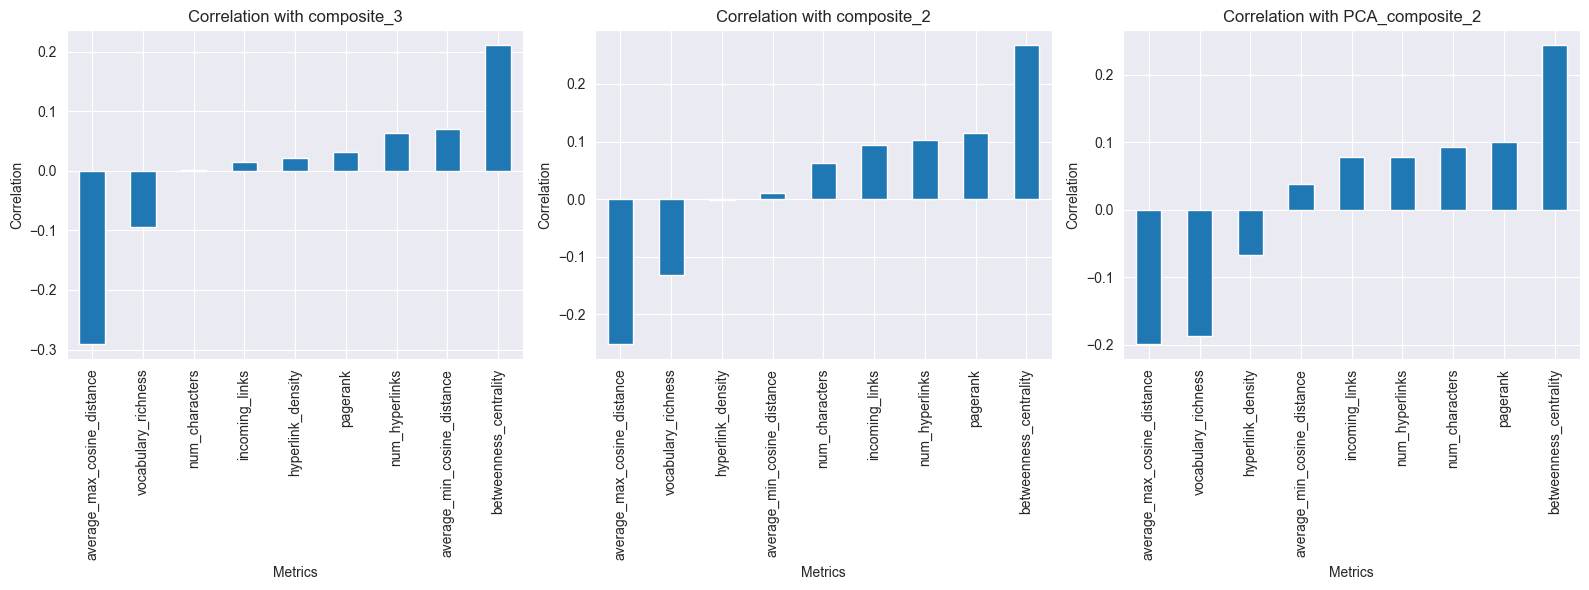

In [33]:
attributes = [ 'num_hyperlinks', 'num_characters', 'hyperlink_density', 'average_max_cosine_distance','average_min_cosine_distance', 'vocabulary_richness','incoming_links','pagerank','betweenness_centrality']
composites = ['composite_3', 'composite_2','PCA_composite_2']

correlations = correlate_attributes(merged_top_1_quality_scores_df, attributes, composites)
print(correlations)
plot_correlations(correlations)

COMMENT

comment about the ML models tried with R^2 close to zero or negative --> not reliable models

## A Machine Learning Approach To Extracting Next Articles

We wanted to see if we could extract non-linear attributes from article text. In order to test this, we created a NN to predict the next article in a path given the following data:
1. The current article text.
2. The next possible articles.
3. The final target article of the current goal.

First, our model uses a pre-trained transformer to extract the attention weights from the current article text. We concatenate those attention weights with the "goal article" id. We then compute logits over the "next possible articles", and return the output of a softmax over those logits. Our full architecture is shown below. Note that we also embed the possible next articles and final target article before passing them to the dense layers.


![Model Architecture](Figures/ModelArch.png)

Overall, after several hours of training, the model reached an accuracy of 20%. From this, we can conclude that the model cannot accurately predict the next article from just the tokenized text.